In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
from scipy import sparse
from scipy import linalg
from scipy.optimize import linear_sum_assignment
import inference
import cluster
import generation_gamma as generation
import metrics
from spectral_operators import BetheHessian

%load_ext autoreload
%autoreload 2

In [2]:
# Matplotlib settings

# plt.style.use('seaborn-whitegrid')

basic_line_color = '#808080'
black = '#222222'
darkgray = '#A9A9A9'
highlight = '#00B2EE'

#color0 = '#7570b3'
#color1 = '#d95f02'
#color3 = '#1b9e77'

color0 = '#1f78b4'
color1 = '#b2df8a'
color2 = '#a6cee3'

plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=24)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['lines.markersize'] = 12

%config InlineBackend.figure_format = 'retina'

In [3]:
def best_score(score_mat, hier):
    groups = [part.k for part in hier]
    pred_lvls, true_lvls = score_mat.shape
    scores = np.zeros(true_lvls)
    n_groups = np.zeros(true_lvls)
    pred_ind, true_ind = linear_sum_assignment(-score_mat)
    for pl, idx in zip(pred_ind, true_ind):
        scores[idx] =  score_mat[pl, idx]
        n_groups[idx] = groups[pl]
    return scores, n_groups

In [4]:
def read_gamma_scores(sym, fileid, use_gamma=True):
    precision = []
    recall = []
    lvl_scores = []
    n_levels = []
    mean_scores = []
    if sym:
        results_file = f'results_me/sym_results{fileid}.txt'
    else:
        results_file = f'results_me/asym_results{fileid}.txt'
    with open(results_file) as rfile:
        results = np.float64([row.strip().split() for row in rfile.readlines()])
    snrs = np.unique(results[:,0])
    gammas = np.unique(results[:,1])
    print(snrs)
    print(gammas)
    if use_gamma:
        for snr in snrs:
            for gamma in gammas:
                idx = (results[:, 0]==snr) * (results[:, 1]==gamma)
                snr_res = results[idx, :]
                mean_scores.append(np.mean(snr_res, 0))
    else:
        for snr in snrs:
            idx = (results[:, 0]==snr)
            snr_res = results[idx, :]
            mean_scores.append(np.mean(snr_res, 0))
    mean_scores = np.array(mean_scores)
    
    return mean_scores

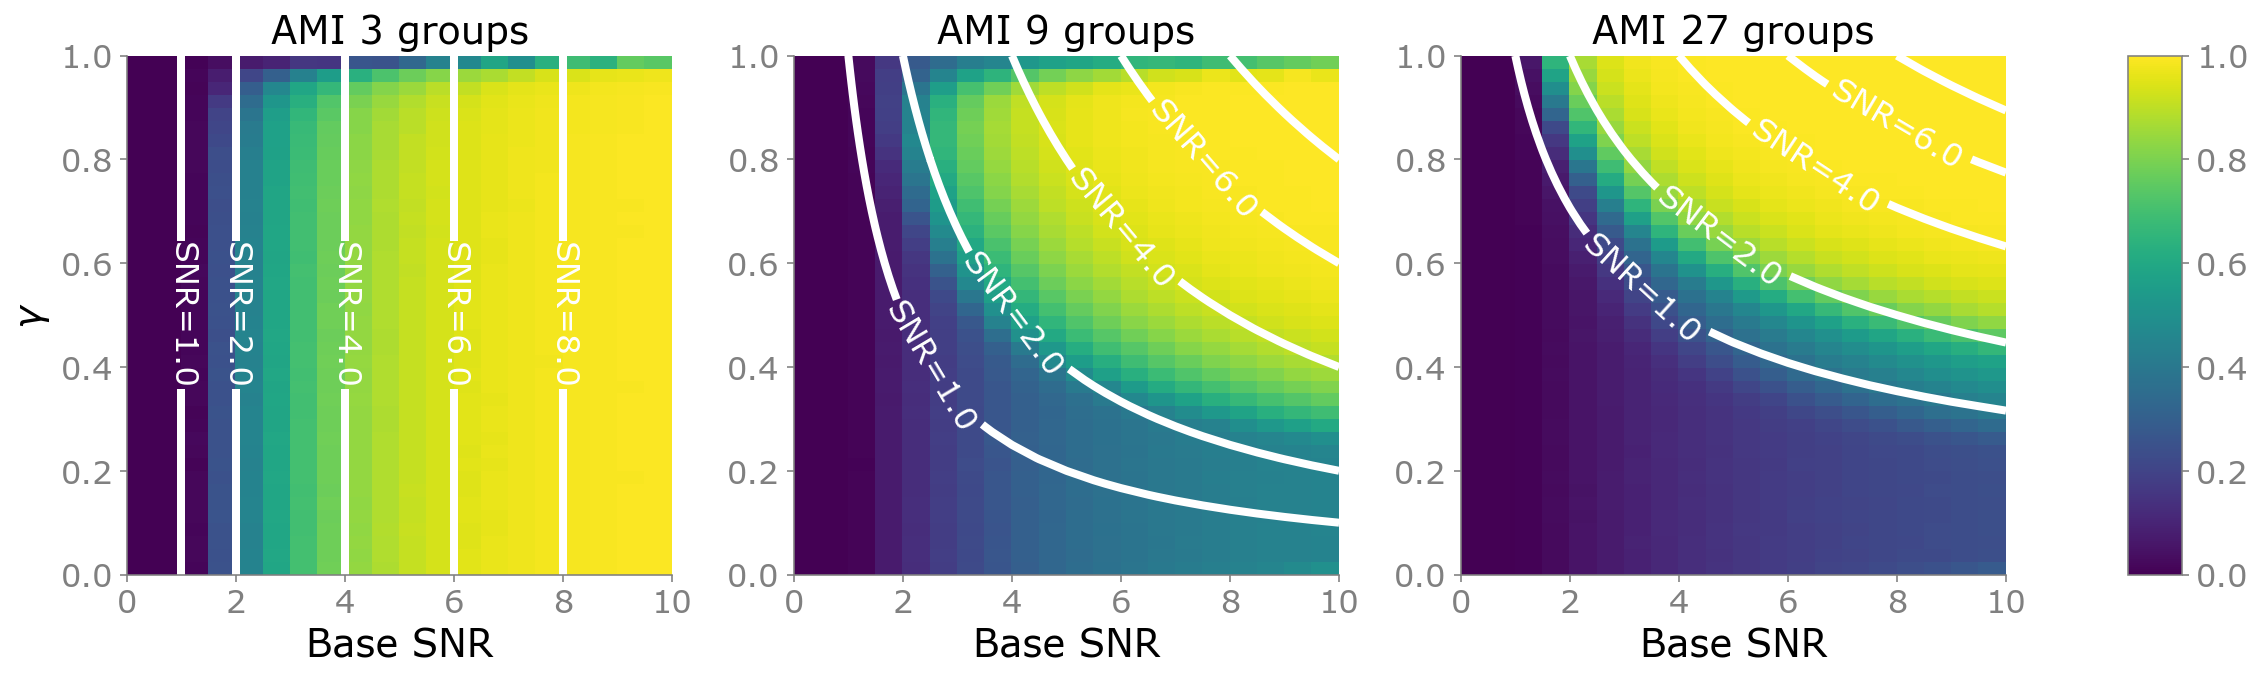

In [11]:
fileid = '27-5gamma-3-3'
mean_scores = read_gamma_scores(True, fileid)
nlevels = mean_scores.shape[1] - 2
snrs = np.unique(mean_scores[:,0])
gammas = np.unique(mean_scores[:,1])

snr_to_idx = dict((s, k) for k, s in enumerate(snrs))
gam_to_idx = dict((f'{g:.4f}', k) for k, g in enumerate(gammas))

snr_v_gam = [np.zeros((len(gammas), len(snrs))) for _ in range(nlevels)]

for scores in mean_scores:
    snr = snr_to_idx[scores[0]]
    gam = gam_to_idx[f'{scores[1]:.4f}']
    for lvl in range(nlevels):
        snr_v_gam[lvl][gam, snr] = scores[lvl+2]

x, y = np.meshgrid(snrs, gammas)

fig = plt.figure(figsize=(16, 5))
widths = [5, 5, 5, .5]
heights = [5]
spec5 = fig.add_gridspec(ncols=nlevels+1, nrows=1, width_ratios=widths,
                           height_ratios=heights)

# fig, axs = plt.subplots(1, nlevels+1, figsize=(16, 5), sharex=True, sharey=True)
Ks = [3, 9, 27]

fmt = r'SNR=%r'

for lvl in range(nlevels):
    ax = fig.add_subplot(spec5[0, lvl])
    im = ax.pcolormesh(x, y, snr_v_gam[lvl], vmin=0, vmax=1)
    cs = ax.contour(x, y, x*(y**lvl), [1,2,4,6,8], colors='w')
    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)
    ax.set(title=f'AMI {Ks[lvl]} groups', xlabel='Base SNR')
    if lvl == 0:
        ax.set(ylabel=r'$\gamma$')
ax = fig.add_subplot(spec5[0, nlevels])
fig.colorbar(im, cax=ax)
plt.tight_layout()

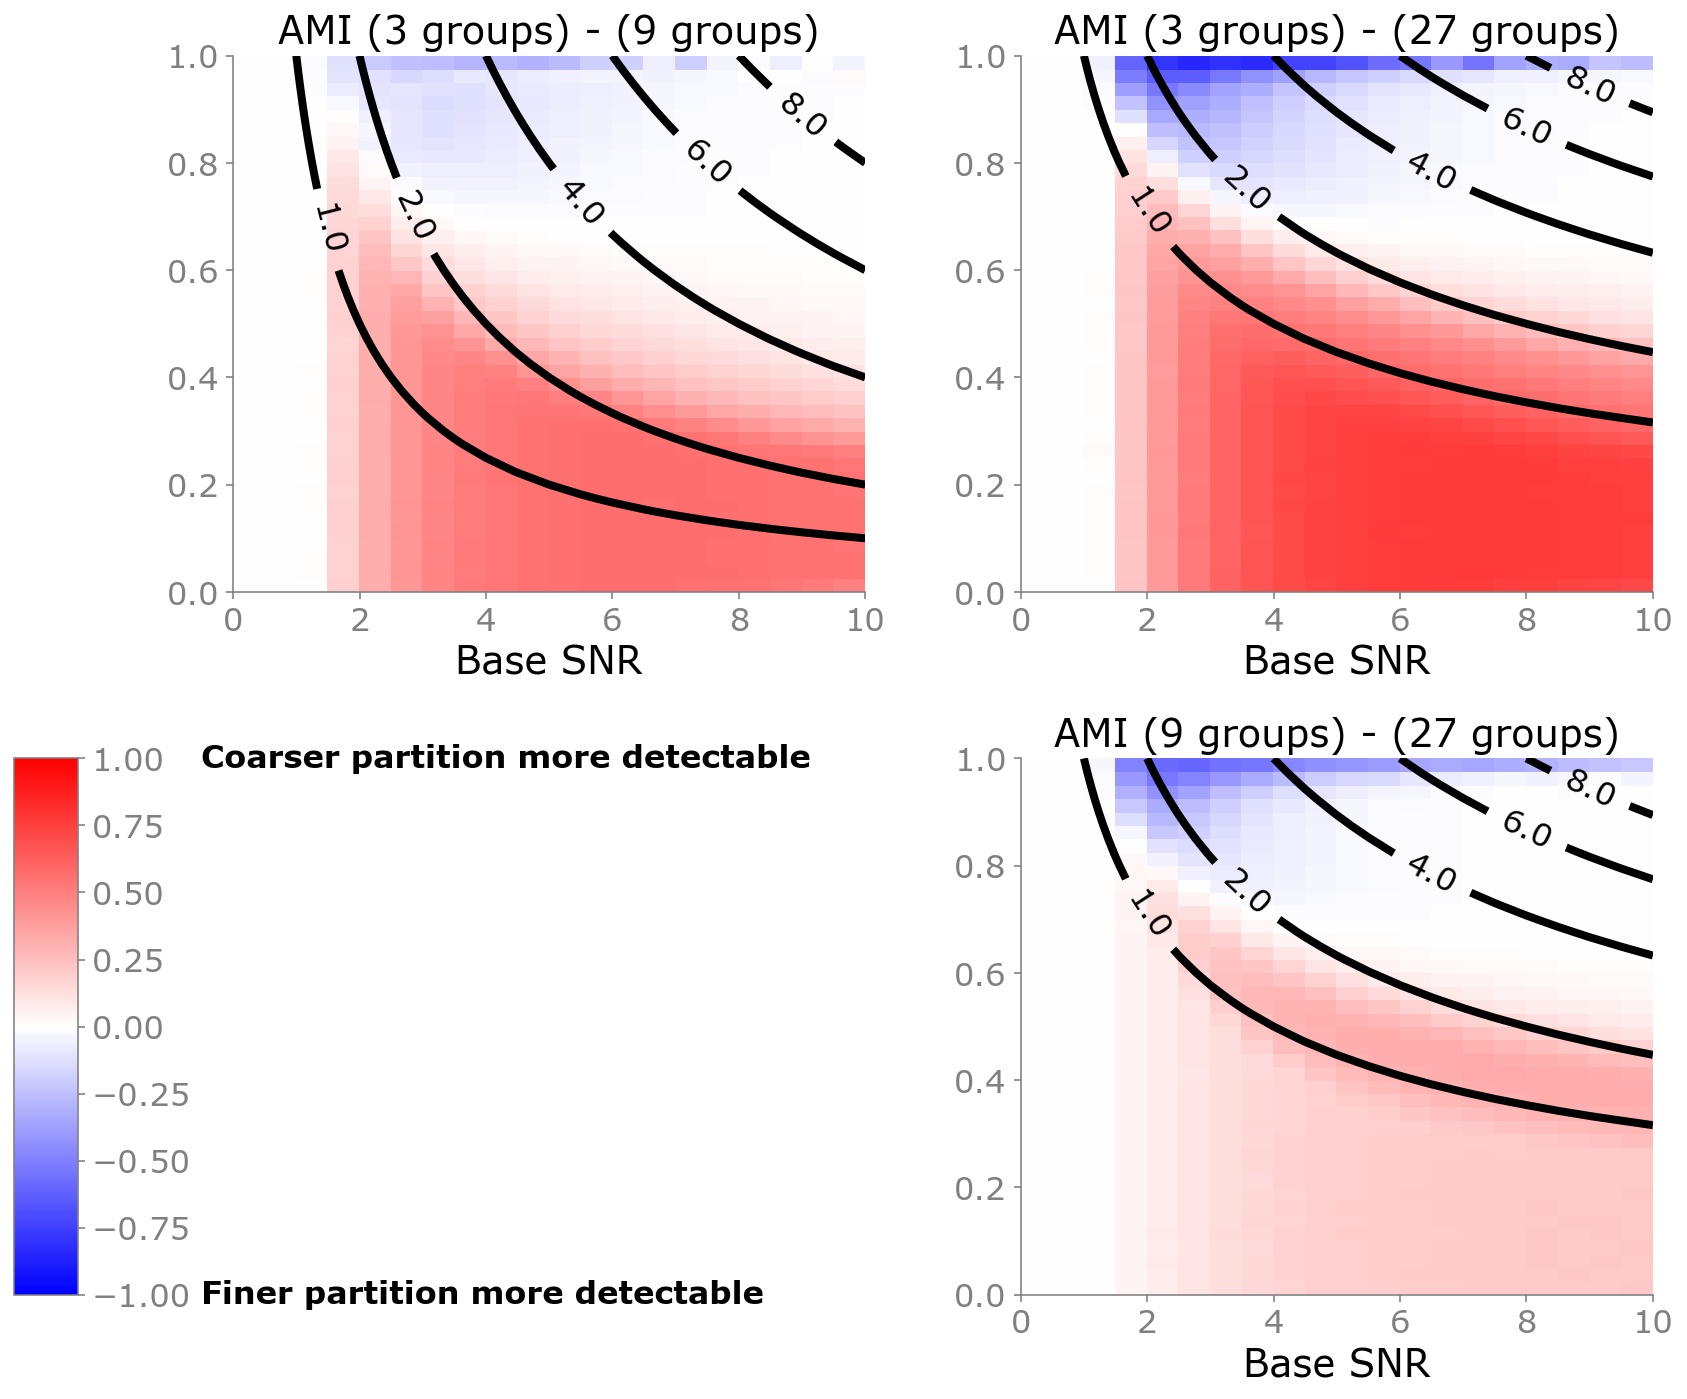

In [279]:
fileid = '27-5gamma-3-3'
mean_scores = read_gamma_scores(True, fileid)
nlevels = mean_scores.shape[1] - 2
snrs = np.unique(mean_scores[:,0])
gammas = np.unique(mean_scores[:,1])

snr_to_idx = dict((s, k) for k, s in enumerate(snrs))
gam_to_idx = dict((f'{g:.4f}', k) for k, g in enumerate(gammas))

snr_v_gam = [np.zeros((len(gammas), len(snrs))) for _ in range(nlevels)]

for scores in mean_scores:
    snr = snr_to_idx[scores[0]]
    gam = gam_to_idx[f'{scores[1]:.4f}']
    for lvl in range(nlevels):
        snr_v_gam[lvl][gam, snr] = scores[lvl+2]

x, y = np.meshgrid(snrs, gammas)

fig = plt.figure(figsize=(12, 10))
widths = [.5] + [5]*(nlevels-1)
heights = [5]*(nlevels-1)
spec5 = fig.add_gridspec(ncols=nlevels, nrows=nlevels-1, width_ratios=widths,
                           height_ratios=heights)

# fig, axs = plt.subplots(1, nlevels+1, figsize=(16, 5), sharex=True, sharey=True)
Ks = [3, 9, 27]

for lvli in range(nlevels):
    for lvlj in range(lvli+1, nlevels):
        ax = fig.add_subplot(spec5[lvli, lvlj])
        im = ax.pcolormesh(x, y, snr_v_gam[lvli] - snr_v_gam[lvlj], vmin=-1, vmax=1, cmap=plt.get_cmap('bwr'))
#         cs = ax.contour(x, y, x*(y**lvli - y**lvlj), 5, colors='k')
        cs = ax.contour(x, y, x*(y**lvlj), [1,2,4,6,8], colors='k')
#         cs = ax.contour(x, y, snr_v_gam[lvli] - snr_v_gam[lvlj], [0], colors='k')
        ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)
        ax.set(title=f'AMI ({Ks[lvli]} groups) - ({Ks[lvlj]} groups)', xlabel='Base SNR')
        if lvlj == 0:
            ax.set(ylabel=r'$\gamma$')
            
ax = fig.add_subplot(spec5[1, 0])
fig.colorbar(im, cax=ax)

ax = fig.add_subplot(spec5[1, 1])
ax.annotate('Coarser partition more detectable', (-0.05, 1), xycoords='axes fraction', va='center', size=16, weight='bold')
ax.annotate('Finer partition more detectable', (-0.05, 0), xycoords='axes fraction', va='center', size=16, weight='bold')
ax.spines['bottom'].set(visible=False)
ax.spines['left'].set(visible=False)
ax.set(xticks=[], yticks=[])
plt.tight_layout()

In [273]:
# QUESTION: can we change the function f(gamma, snr) such that the above plots have horizontal bars?
# Repeat the above plots with the snr (instead of AMI),
# 2 ways: (a) using average cout and (b) using eigenvalues

/home/leto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: No contour levels were found within the data range.


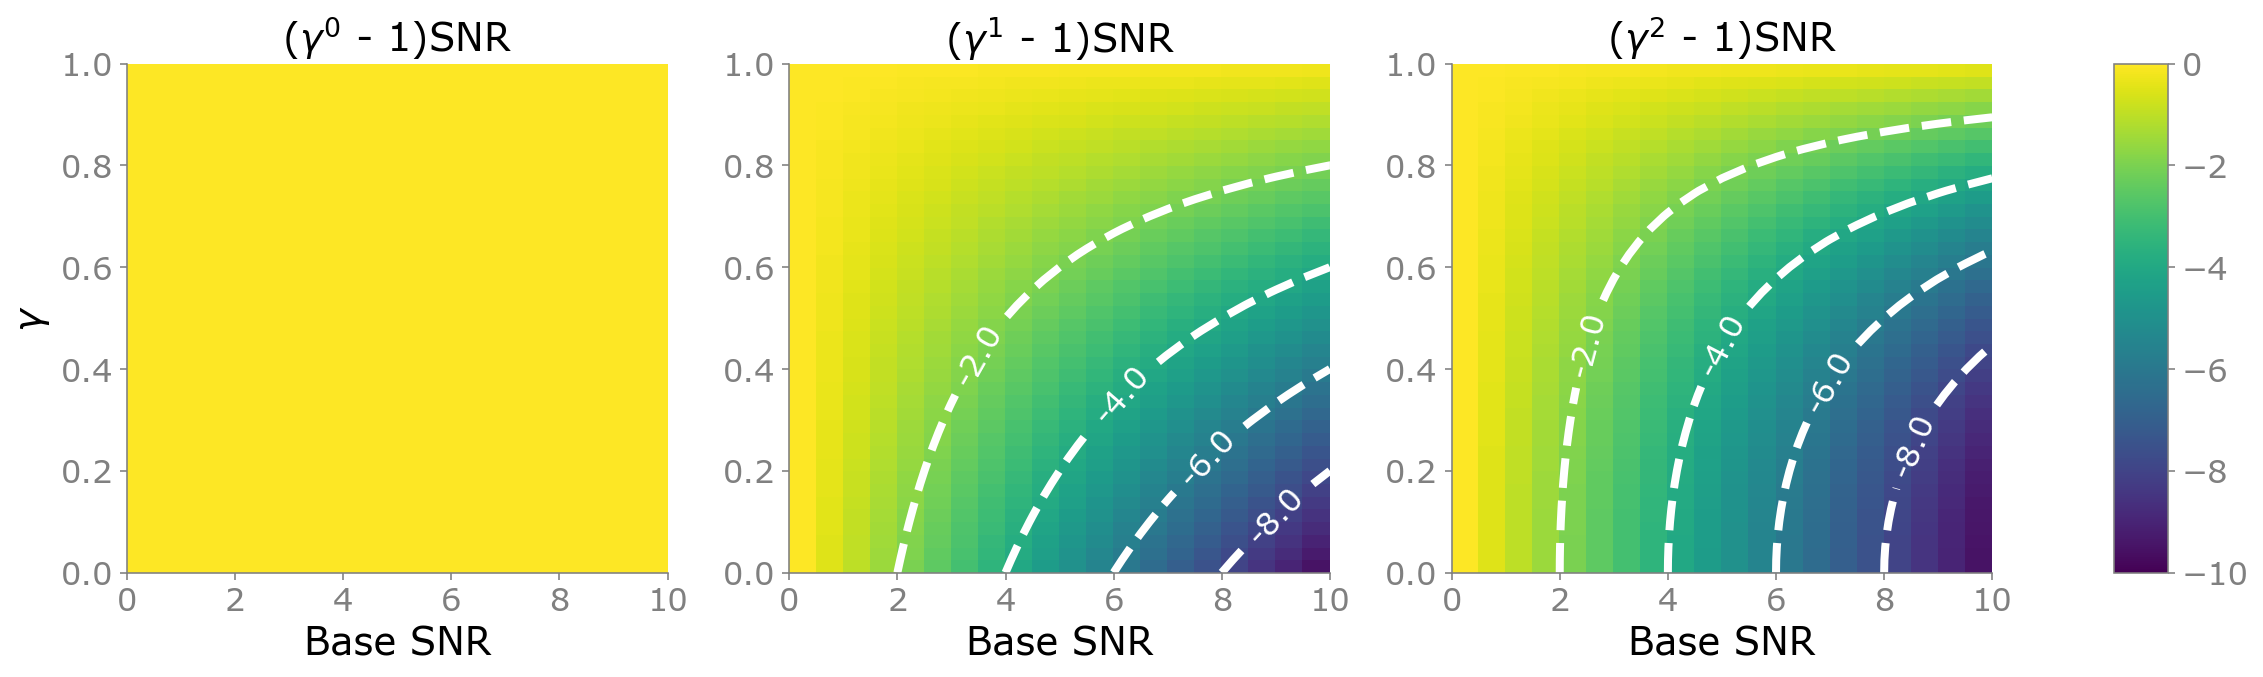

In [306]:
# fileid = '27-5gamma-3-3'
mean_scores = read_gamma_scores(True, fileid)
nlevels = mean_scores.shape[1] - 2
snrs = np.unique(mean_scores[:,0])
gammas = np.unique(mean_scores[:,1])

snr_to_idx = dict((s, k) for k, s in enumerate(snrs))
gam_to_idx = dict((f'{g:.4f}', k) for k, g in enumerate(gammas))

snr_v_gam = [np.zeros((len(gammas), len(snrs))) for _ in range(nlevels)]

for scores in mean_scores:
    snr = snr_to_idx[scores[0]]
    gam = gam_to_idx[f'{scores[1]:.4f}']
    for lvl in range(nlevels):
        snr_v_gam[lvl][gam, snr] = scores[lvl+2]

x, y = np.meshgrid(snrs, gammas)

fig = plt.figure(figsize=(16, 5))
widths = [5, 5, 5, .5]
heights = [5]
spec5 = fig.add_gridspec(ncols=nlevels+1, nrows=1, width_ratios=widths,
                           height_ratios=heights)

# fig, axs = plt.subplots(1, nlevels+1, figsize=(16, 5), sharex=True, sharey=True)
Ks = [3, 9, 27]

fmt = r'%r'

for lvl in range(nlevels):
    ax = fig.add_subplot(spec5[0, lvl])
    im = ax.pcolormesh(x, y, x*(y**lvl)-x, vmin=-10, vmax=0)
    cs = ax.contour(x, y, x*(y**lvl)-x, 5, colors='w')
    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)
    ax.set(title=f'($\gamma^{lvl}$ - 1)SNR', xlabel='Base SNR')
    if lvl == 0:
        ax.set(ylabel=r'$\gamma$')
ax = fig.add_subplot(spec5[0, nlevels])
fig.colorbar(im, cax=ax)
plt.tight_layout()

/home/leto/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/leto/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


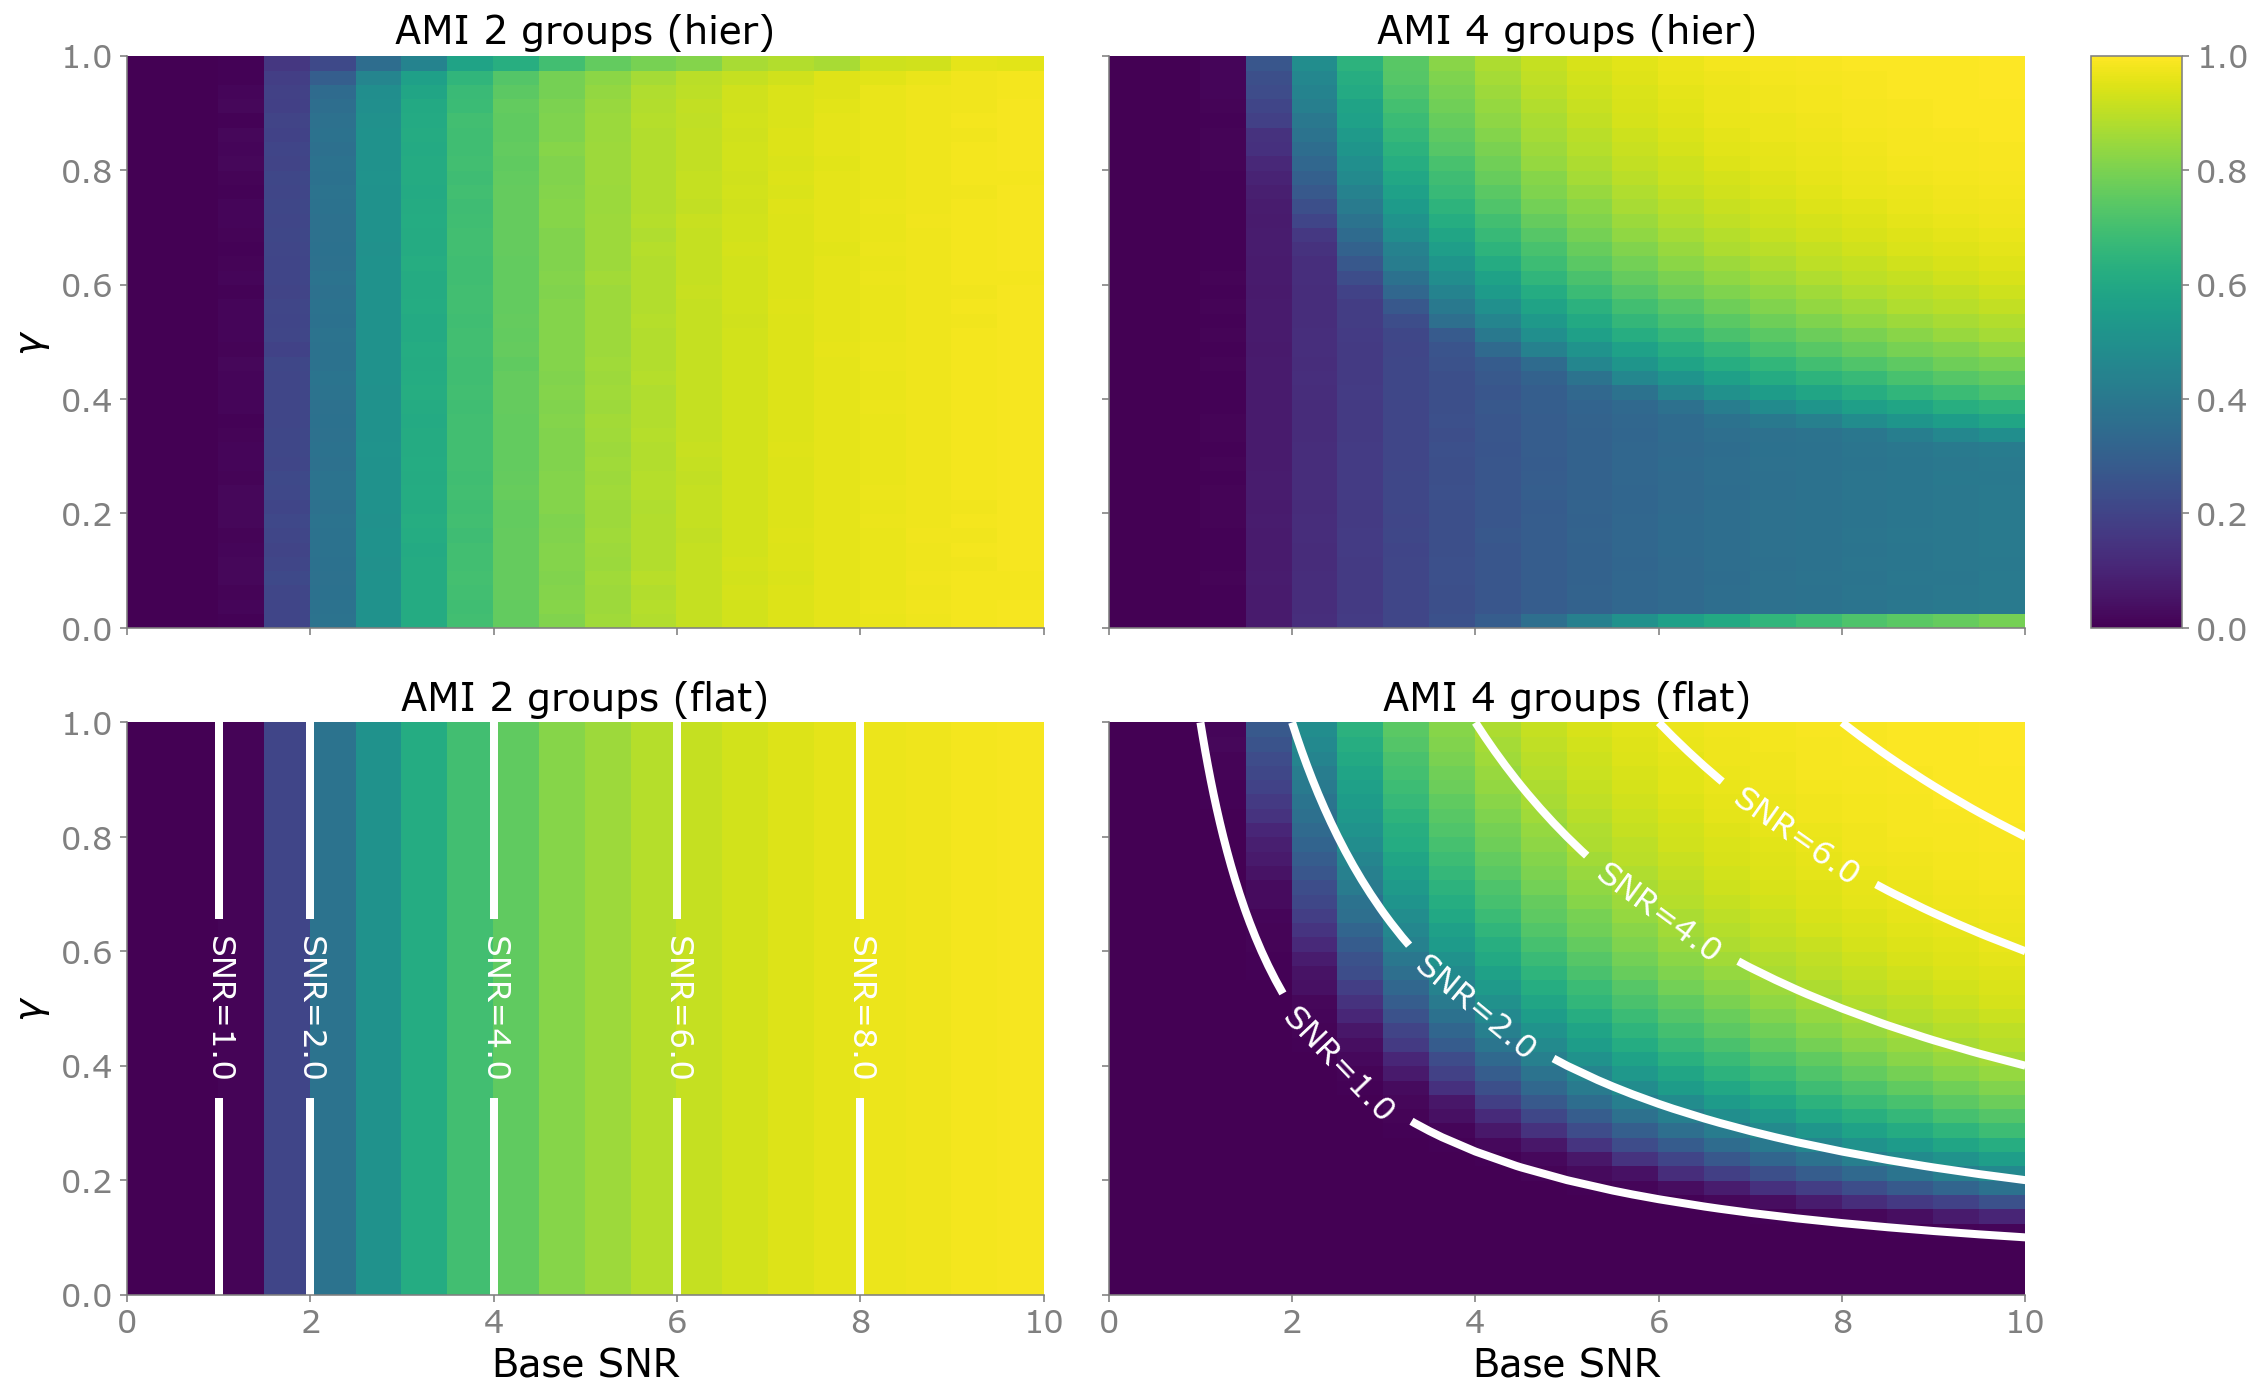

In [237]:
fileid = '01-6gamma-2-2'
mean_scores = read_gamma_scores(True, fileid)
nlevels = mean_scores.shape[1] - 2
snrs = np.unique(mean_scores[:,0])
gammas = np.unique(mean_scores[:,1])

snr_to_idx = dict((s, k) for k, s in enumerate(snrs))
gam_to_idx = dict((f'{g:.4f}', k) for k, g in enumerate(gammas))

snr_v_gam = [np.zeros((len(gammas), len(snrs))) for _ in range(nlevels)]

for scores in mean_scores:
    snr = snr_to_idx[scores[0]]
    gam = gam_to_idx[f'{scores[1]:.4f}']
    for lvl in range(nlevels):
        snr_v_gam[lvl][gam, snr] = scores[lvl+2]

x, y = np.meshgrid(snrs, gammas)

fig = plt.figure(figsize=(16, 10))
widths = [5, 5, .5]
heights = [5, 5]
spec5 = fig.add_gridspec(ncols=nlevels+1, nrows=2, width_ratios=widths,
                           height_ratios=heights)

# fig, axs = plt.subplots(1, nlevels+1, figsize=(16, 5), sharex=True, sharey=True)
Ks = [2, 4]

fmt = r'SNR=%r'

for lvl in range(nlevels):
    if lvl == 0:
        ax = fig.add_subplot(spec5[0, lvl])
        ax1=ax
    else:
        ax = fig.add_subplot(spec5[0, lvl], sharex=ax1, sharey=ax1)
    im = ax.pcolormesh(x, y, snr_v_gam[lvl], vmin=0, vmax=1)
#     cs = ax.contour(x, y, x*(y**lvl), [1,2,4,6,8], colors='w')
#     ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)
    ax.set(title=f'AMI {Ks[lvl]} groups (hier)')
    plt.setp(ax.get_xticklabels(), visible=False)
    if lvl == 0:
        ax.set(ylabel=r'$\gamma$')
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
ax = fig.add_subplot(spec5[0, nlevels])
fig.colorbar(im, cax=ax)


fileid = '01-6gamma-1-2'
mean_scores = read_gamma_scores(True, fileid)

snr_v_gam1_2 = np.zeros((len(gammas), len(snrs)))

for scores in mean_scores:
    snr = snr_to_idx[scores[0]]
    gam = gam_to_idx[f'{scores[1]:.4f}']
    snr_v_gam1_2[:, snr] = scores[2]


ax = fig.add_subplot(spec5[1, 0], sharex=ax1, sharey=ax1)
im = ax.pcolormesh(x, y, snr_v_gam1_2, vmin=0, vmax=1)
cs = ax.contour(x, y, x, [1,2,4,6,8], colors='w')
ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)

ax.set(ylabel=r'$\gamma$', title='AMI 2 groups (flat)', xlabel='Base SNR')


fileid = '01-6gamma-1-4'
mean_scores = read_gamma_scores(True, fileid)

snr_v_gam1_4 = np.zeros((len(gammas), len(snrs)))

snr_gam_dict = {}

for scores in mean_scores:
    snr_gam_dict[f'{scores[0]:.4f} {scores[1]:.4f}'] = scores[2]

for gi, gam in enumerate(gammas):
    for sj, snr in enumerate(snrs):
        snr_v_gam1_4[gi, sj] = snr_gam_dict[f'{snr*gam:.4f} {gam:.4f}']

ax = fig.add_subplot(spec5[1, 1], sharex=ax1, sharey=ax1)
im = ax.pcolormesh(x, y, snr_v_gam1_4, vmin=0, vmax=1)
cs = ax.contour(x, y, x*y, [1,2,4,6,8], colors='w')
ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)

ax.set(title='AMI 4 groups (flat)', xlabel='Base SNR')
plt.setp(ax.get_yticklabels(), visible=False)

plt.tight_layout()
plt.savefig('performace_hierVflat2-2.pdf')

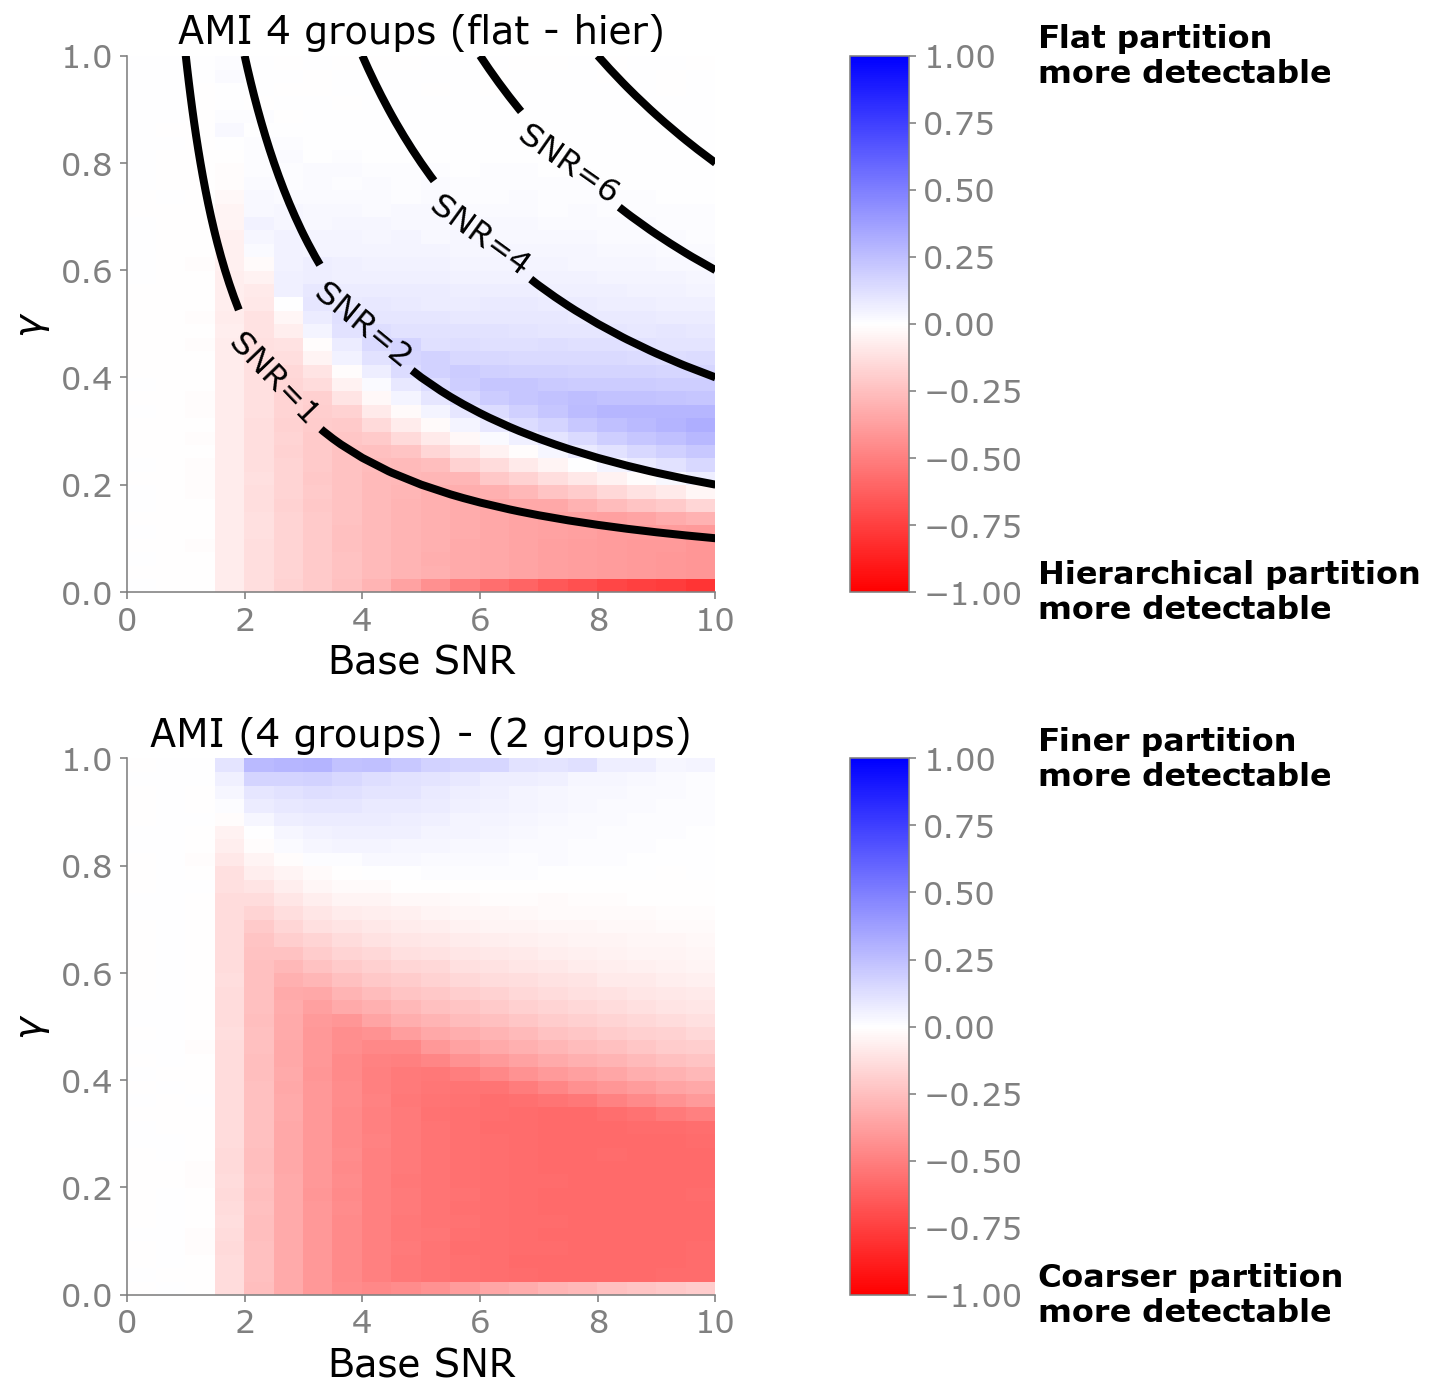

In [235]:
fig = plt.figure(figsize=(10, 10))
widths = [10, 1, 2]
heights = [5, 5]
spec5 = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)

fmt = r' SNR=%.0f '

ax = fig.add_subplot(spec5[0, 0])

im = ax.pcolormesh(x, y, snr_v_gam1_4 - snr_v_gam[1], cmap=plt.get_cmap('bwr_r'), vmin=-1, vmax=1)
cs = ax.contour(x, y, x*(y**1), [1,2,4,6,8], colors='k')
ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)
ax.set(ylabel=r'$\gamma$', title='AMI 4 groups (flat - hier)', xlabel='Base SNR')

ax = fig.add_subplot(spec5[0, 1])
fig.colorbar(im, cax=ax)

ax = fig.add_subplot(spec5[1, 0])

im = ax.pcolormesh(x, y, snr_v_gam[1] - snr_v_gam[0], cmap=plt.get_cmap('bwr_r'), vmin=-1, vmax=1)
ax.set(ylabel=r'$\gamma$', title='AMI (4 groups) - (2 groups)', xlabel='Base SNR')

ax = fig.add_subplot(spec5[1, 1])
fig.colorbar(im, cax=ax)

ax = fig.add_subplot(spec5[0, 2])
ax.annotate('Flat partition\n more detectable', (-0.05, 1), wrap=True, xycoords='axes fraction', va='center', size=16, weight='bold')
ax.annotate('Hierarchical partition\n more detectable', (-0.05, 0), wrap=True, xycoords='axes fraction', va='center', size=16, weight='bold')
ax.spines['bottom'].set(visible=False)
ax.spines['left'].set(visible=False)
ax.set(xticks=[], yticks=[])

ax = fig.add_subplot(spec5[1, 2])
ax.annotate('Finer partition\n more detectable', (-0.05, 1), wrap=True, xycoords='axes fraction', va='center', size=16, weight='bold')
ax.annotate('Coarser partition\n more detectable', (-0.05, 0), wrap=True, xycoords='axes fraction', va='center', size=16, weight='bold')
ax.spines['bottom'].set(visible=False)
ax.spines['left'].set(visible=False)
ax.set(xticks=[], yticks=[])
plt.tight_layout()
plt.savefig('performace_difference2-2.pdf')

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]
[1.]
[ 0.      0.0125  0.025   0.0375  0.05    0.0625  0.075   0.0875  0.1
  0.1125  0.1125  0.125   0.1375  0.15    0.1625  0.175   0.1875  0.1875
  0.2     0.2125  0.225   0.225   0.2375  0.25    0.2625  0.2625  0.275
  0.2875  0.3     0.3125  0.325   0.3375  0.35    0.3625  0.375   0.375
  0.3875  0.4     0.4125  0.4125  0.425   0.4375  0.4375  0.45    0.45
  0.4625  0.475   0.4875  0.5     0.525   0.525   0.55    0.5625  0.5625
  0.575   0.6     0.6125  0.625   0.6375  0.65    0.675   0.6875  0.7
  0.7125  0.7125  0.725   0

/home/leto/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/leto/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


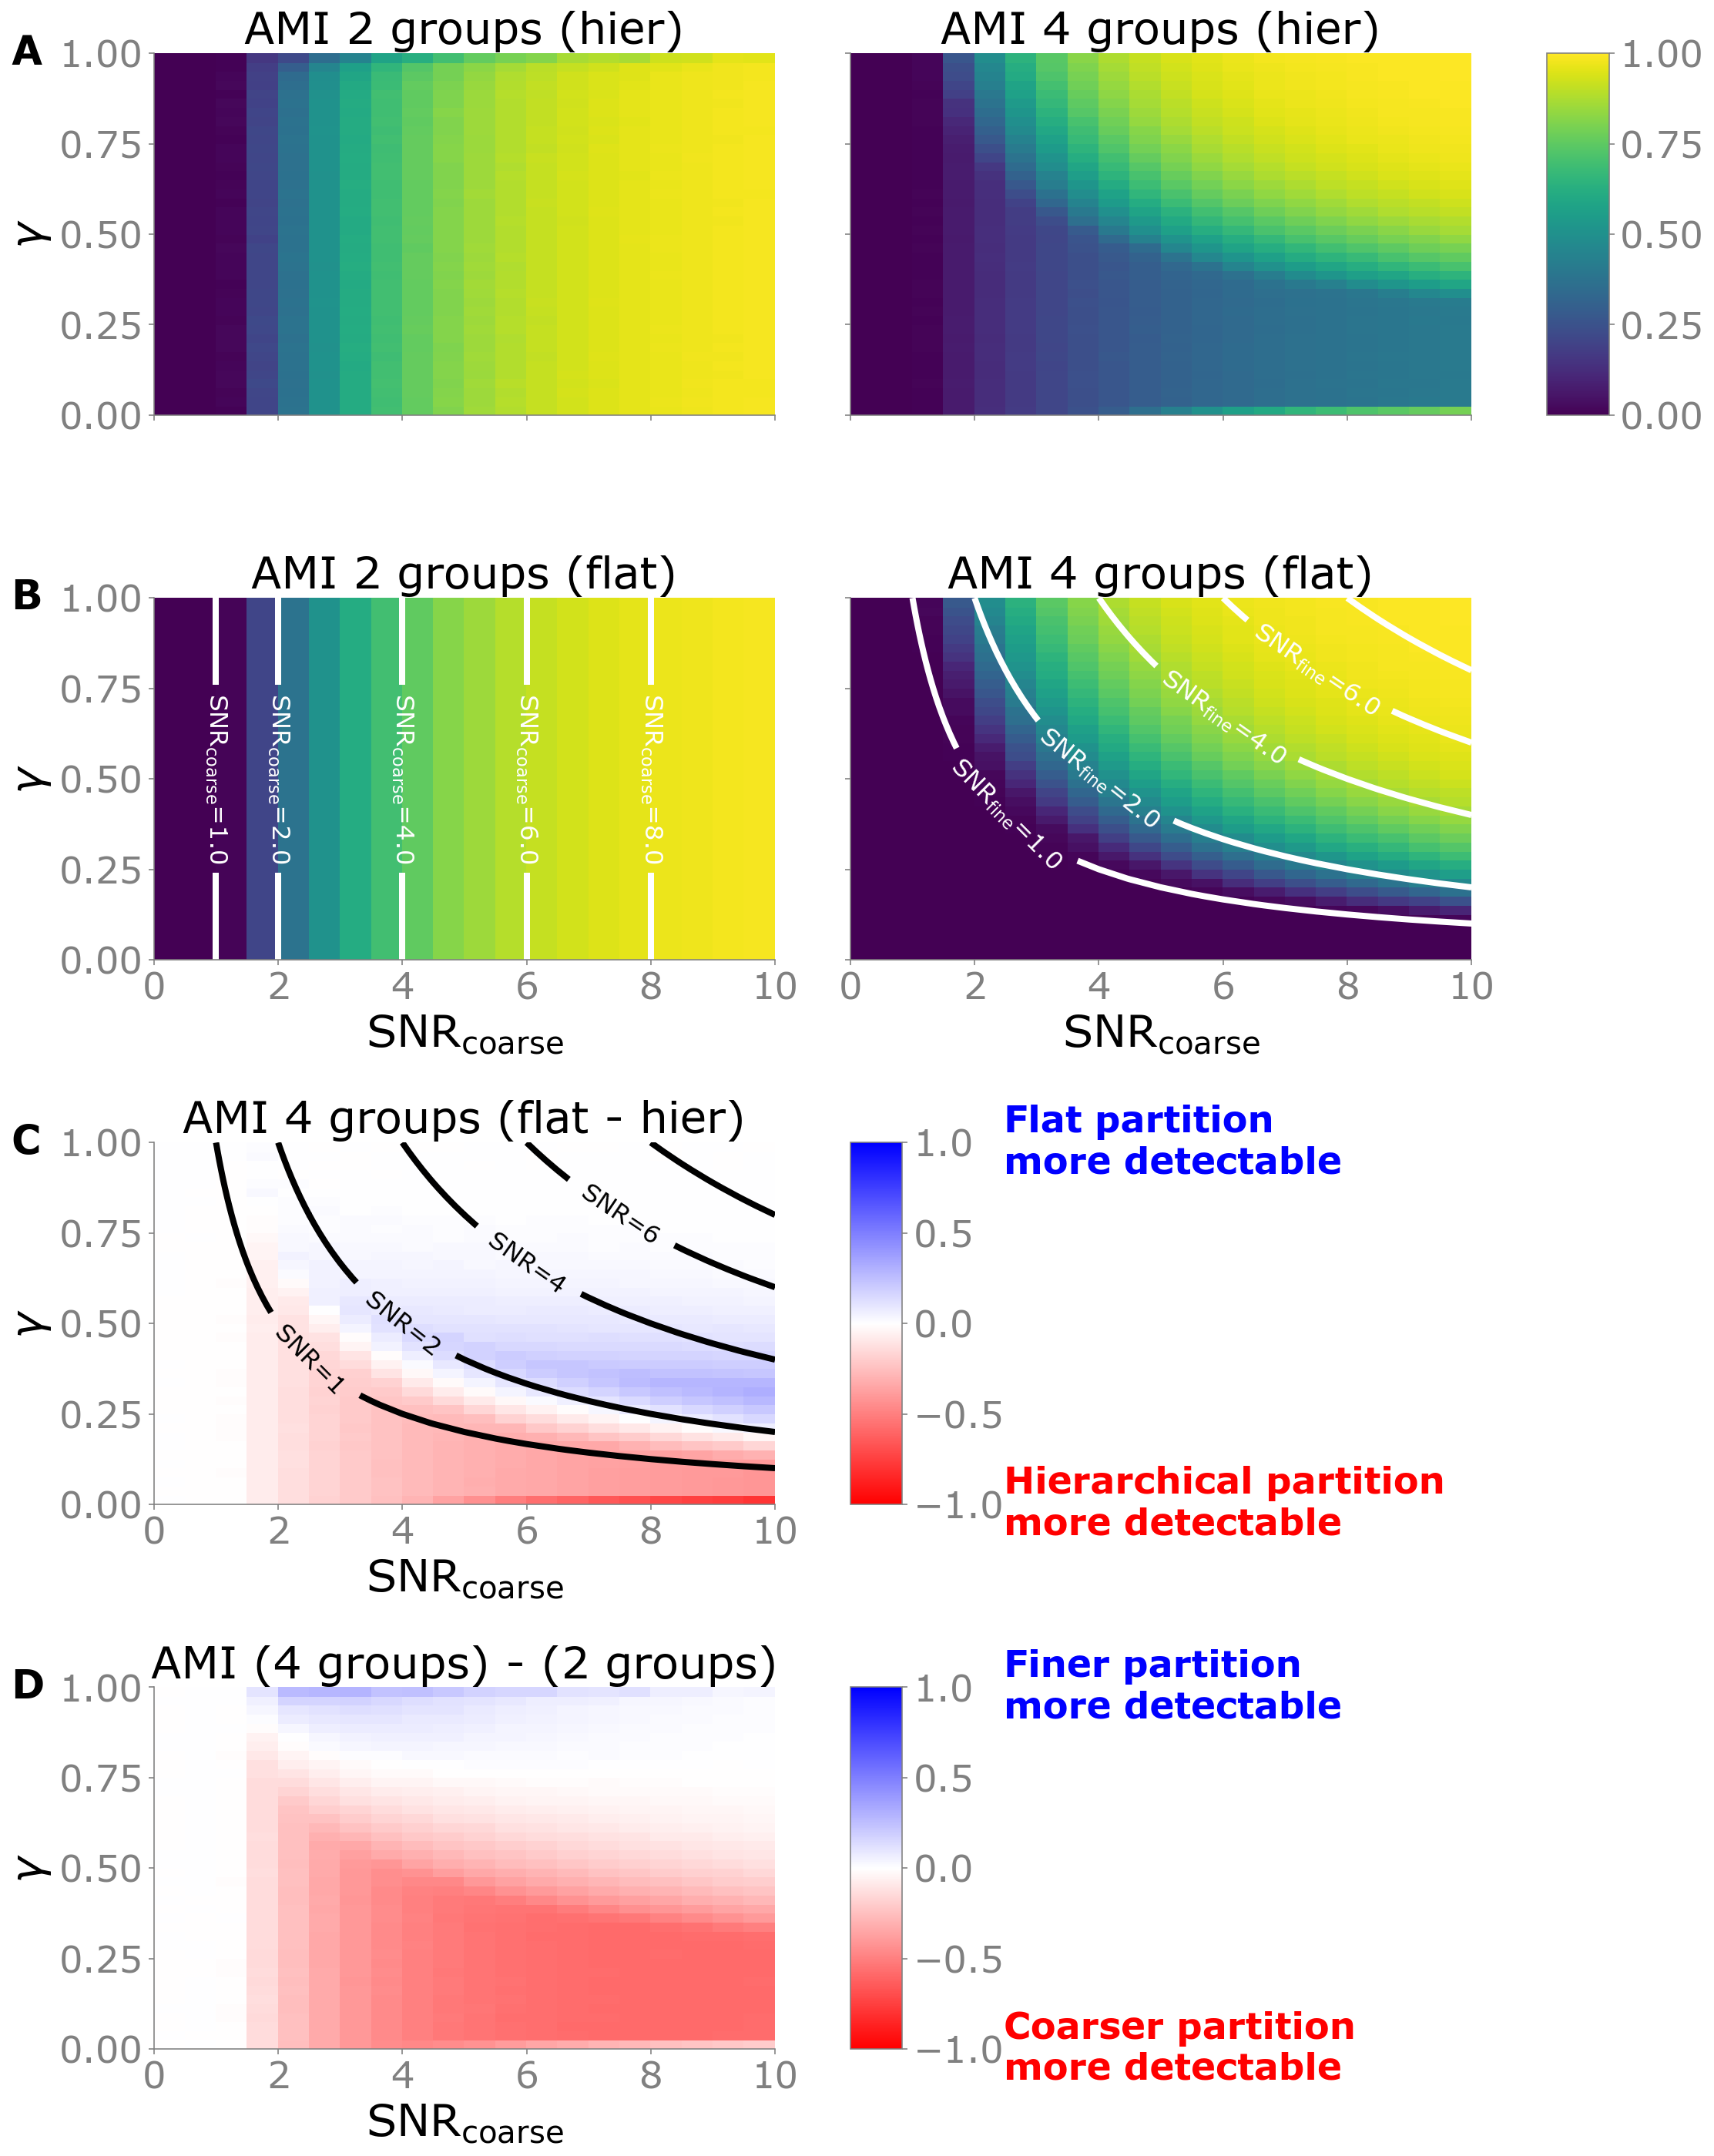

In [79]:
fileid = '01-6gamma-2-2'
mean_scores = read_gamma_scores(True, fileid)
nlevels = mean_scores.shape[1] - 2
snrs = np.unique(mean_scores[:,0])
gammas = np.unique(mean_scores[:,1])

snr_to_idx = dict((s, k) for k, s in enumerate(snrs))
gam_to_idx = dict((f'{g:.4f}', k) for k, g in enumerate(gammas))

snr_v_gam = [np.zeros((len(gammas), len(snrs))) for _ in range(nlevels)]

for scores in mean_scores:
    snr = snr_to_idx[scores[0]]
    gam = gam_to_idx[f'{scores[1]:.4f}']
    for lvl in range(nlevels):
        snr_v_gam[lvl][gam, snr] = scores[lvl+2]

x, y = np.meshgrid(snrs, gammas)

fig = plt.figure(figsize=(16, 20))
widths = [5, 5, .5]
heights = [3, 3, 3, 3]
spec5 = fig.add_gridspec(ncols=3, nrows=4, width_ratios=widths, height_ratios=heights)

# fig, axs = plt.subplots(1, nlevels+1, figsize=(16, 5), sharex=True, sharey=True)
Ks = [2, 4]

for lvl in range(nlevels):
    if lvl == 0:
        ax = fig.add_subplot(spec5[0, lvl])
        ax1=ax
    else:
        ax = fig.add_subplot(spec5[0, lvl], sharex=ax1, sharey=ax1)
    im = ax.pcolormesh(x, y, snr_v_gam[lvl], vmin=0, vmax=1)
#     cs = ax.contour(x, y, x*(y**lvl), [1,2,4,6,8], colors='w')
#     ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)
    ax.set(title=f'AMI {Ks[lvl]} groups (hier)')
    plt.setp(ax.get_xticklabels(), visible=False)
    if lvl == 0:
        ax.set(ylabel=r'$\gamma$')
        ax.annotate('A', (-0.23, 1), xycoords='axes fraction', va='center', size=26, weight='bold')
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
ax = fig.add_subplot(spec5[0, nlevels])
fig.colorbar(im, cax=ax)


fileid = '01-6gamma-1-2'
mean_scores = read_gamma_scores(True, fileid)

snr_v_gam1_2 = np.zeros((len(gammas), len(snrs)))

for scores in mean_scores:
    snr = snr_to_idx[scores[0]]
    gam = gam_to_idx[f'{scores[1]:.4f}']
    snr_v_gam1_2[:, snr] = scores[2]

fmt = r'SNR$_{\rm{coarse}}$=%r'

ax = fig.add_subplot(spec5[1, 0], sharex=ax1, sharey=ax1)
im = ax.pcolormesh(x, y, snr_v_gam1_2, vmin=0, vmax=1)
cs = ax.contour(x, y, x, [1,2,4,6,8], colors='w')
ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)

ax.set(ylabel=r'$\gamma$', title='AMI 2 groups (flat)', xlabel=r'SNR$_{\rm{coarse}}$')
ax.annotate('B', (-0.23, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

fileid = '01-6gamma-1-4'
mean_scores = read_gamma_scores(True, fileid)

snr_v_gam1_4 = np.zeros((len(gammas), len(snrs)))

snr_gam_dict = {}

for scores in mean_scores:
    snr_gam_dict[f'{scores[0]:.4f} {scores[1]:.4f}'] = scores[2]

for gi, gam in enumerate(gammas):
    for sj, snr in enumerate(snrs):
        snr_v_gam1_4[gi, sj] = snr_gam_dict[f'{snr*gam:.4f} {gam:.4f}']

fmt = r'SNR$_{\rm{fine}}$=%r'
        
ax = fig.add_subplot(spec5[1, 1], sharex=ax1, sharey=ax1)
im = ax.pcolormesh(x, y, snr_v_gam1_4, vmin=0, vmax=1)
cs = ax.contour(x, y, x*y, [1,2,4,6,8], colors='w')
ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)

ax.set(title='AMI 4 groups (flat)', xlabel=r'SNR$_{\rm{coarse}}$')
plt.setp(ax.get_yticklabels(), visible=False)

# plt.tight_layout()
# plt.savefig('performace_hierVflat2-2.pdf')

##############

# widths = [10, 1, 2]
# heights = [5, 5]
# spec5 = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)

fmt = r' SNR=%.0f '

ax = fig.add_subplot(spec5[2, 0])

im = ax.pcolormesh(x, y, snr_v_gam1_4 - snr_v_gam[1], cmap=plt.get_cmap('bwr_r'), vmin=-1, vmax=1)
cs = ax.contour(x, y, x*(y**1), [1,2,4,6,8], colors='k')
ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)
ax.set(ylabel=r'$\gamma$', title='AMI 4 groups (flat - hier)', xlabel=r'SNR$_{\rm{coarse}}$')

ax.annotate('C', (-0.23, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

widths = [.5, 5]
heights = [5]
inner1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=spec5[2, 1], width_ratios=widths, height_ratios=heights)

ax = fig.add_subplot(inner1[0, 0])
fig.colorbar(im, cax=ax)

ax = fig.add_subplot(spec5[3, 0])

im = ax.pcolormesh(x, y, snr_v_gam[1] - snr_v_gam[0], cmap=plt.get_cmap('bwr_r'), vmin=-1, vmax=1)
ax.set(ylabel=r'$\gamma$', title='AMI (4 groups) - (2 groups)', xlabel=r'SNR$_{\rm{coarse}}$')

ax.annotate('D', (-0.23, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

inner2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=spec5[3, 1], width_ratios=widths, height_ratios=heights)

ax = fig.add_subplot(inner2[0, 0])
fig.colorbar(im, cax=ax)

cmap = plt.get_cmap('bwr')

ax = fig.add_subplot(inner1[0, 1])
ax.annotate('Flat partition\nmore detectable', (0.1, 1), color=cmap(0), xycoords='axes fraction', va='center', size=24, weight='bold')
ax.annotate('Hierarchical partition\nmore detectable', (0.1, 0), color=cmap(1000), xycoords='axes fraction', va='center', size=24, weight='bold')
ax.spines['bottom'].set(visible=False)
ax.spines['left'].set(visible=False)
ax.set(xticks=[], yticks=[])
ax.patch.set_alpha(0.)

ax = fig.add_subplot(inner2[0, 1])
ax.annotate('Finer partition\nmore detectable', (0.1, 1), color=cmap(0), xycoords='axes fraction', va='center', size=24, weight='bold')
ax.annotate('Coarser partition\nmore detectable', (0.1, 0), color=cmap(1000), xycoords='axes fraction', va='center', size=24, weight='bold')
ax.spines['bottom'].set(visible=False)
ax.spines['left'].set(visible=False)
ax.set(xticks=[], yticks=[])
ax.patch.set_alpha(0.)
plt.tight_layout()
plt.savefig('performace_2-2.pdf')

In [ ]:
fileid = '01-6gamma-2-2'
mean_scores = read_gamma_scores(True, fileid)
nlevels = mean_scores.shape[1] - 2
snrs = np.unique(mean_scores[:,0])
gammas = np.unique(mean_scores[:,1])

snr_to_idx = dict((s, k) for k, s in enumerate(snrs))
gam_to_idx = dict((f'{g:.4f}', k) for k, g in enumerate(gammas))

snr_v_gam = [np.zeros((len(gammas), len(snrs))) for _ in range(nlevels)]

for scores in mean_scores:
    snr = snr_to_idx[scores[0]]
    gam = gam_to_idx[f'{scores[1]:.4f}']
    for lvl in range(nlevels):
        snr_v_gam[lvl][gam, snr] = scores[lvl+2]

x, y = np.meshgrid(snrs, gammas)

fig = plt.figure(figsize=(16, 12))
widths = [5, 3]
heights = [3, 3]
spec5 = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

# fig, axs = plt.subplots(1, nlevels+1, figsize=(16, 5), sharex=True, sharey=True)
Ks = [2, 4]


fmt = r' SNR$_{\rm{PP}}$=%.0f '

ax = fig.add_subplot(spec5[0, 0])

im = ax.pcolormesh(x, y, snr_v_gam1_4 - snr_v_gam[1], cmap=plt.get_cmap('bwr_r'), vmin=-1, vmax=1)
cs = ax.contour(x, y, x*(y**1), [1,2,4,6,8], colors='k')
ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)
ax.set(ylabel=r'$\gamma$', title='AMI 4 groups (flat - hier)', xlabel=r'SNR$_{\rm{coarse}}$')

ax.annotate('A', (-0.23, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

widths = [.5, 5]
heights = [5]
inner1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=spec5[0, 1], width_ratios=widths, height_ratios=heights)

ax = fig.add_subplot(inner1[0, 0])
fig.colorbar(im, cax=ax)

ax = fig.add_subplot(spec5[1, 0])

im = ax.pcolormesh(x, y, snr_v_gam[1] - snr_v_gam[0], cmap=plt.get_cmap('bwr_r'), vmin=-1, vmax=1)
ax.set(ylabel=r'$\gamma$', title='AMI (4 groups) - (2 groups)', xlabel=r'SNR$_{\rm{coarse}}$')

ax.annotate('B', (-0.23, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

inner2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=spec5[1, 1], width_ratios=widths, height_ratios=heights)

ax = fig.add_subplot(inner2[0, 0])
fig.colorbar(im, cax=ax)

cmap = plt.get_cmap('bwr')

ax = fig.add_subplot(inner1[0, 1])
ax.annotate('Flat partition\nmore detectable', (0.17, 1), color=cmap(0), xycoords='axes fraction', va='center', size=24, weight='bold')
ax.annotate('Hierarchical partition\nmore detectable', (0.17, 0), color=cmap(1000), xycoords='axes fraction', va='center', size=24, weight='bold')
ax.spines['bottom'].set(visible=False)
ax.spines['left'].set(visible=False)
ax.set(xticks=[], yticks=[])
ax.patch.set_alpha(0.)

ax = fig.add_subplot(inner2[0, 1])
ax.annotate('Finer partition\nmore detectable', (0.17, 1), color=cmap(0), xycoords='axes fraction', va='center', size=24, weight='bold')
ax.annotate('Coarser partition\nmore detectable', (0.17, 0), color=cmap(1000), xycoords='axes fraction', va='center', size=24, weight='bold')
ax.spines['bottom'].set(visible=False)
ax.spines['left'].set(visible=False)
ax.set(xticks=[], yticks=[])
ax.patch.set_alpha(0.)
plt.tight_layout()
plt.savefig('performace_2-2.pdf')

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]


In [7]:
fileid = '01-6gammaSNR25c150-2-2'
mean_scores = read_gamma_scores(True, fileid)
list(zip(mean_scores[:, 1], mean_scores[:, 3]))

[25.]
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.    1.025 1.05  1.075 1.1   1.125 1.15  1.175
 1.2   1.225 1.25  1.275 1.3   1.325 1.35  1.375 1.4   1.425 1.45  1.475
 1.5   1.525 1.55  1.575 1.6   1.625 1.65  1.675 1.7   1.725 1.75  1.775
 1.8   1.825 1.85  1.875 1.9   1.925 1.95  1.975 2.   ]


[(0.0, 0.987487544966459),
 (0.024999999999999998, 0.7019878452811525),
 (0.049999999999999996, 0.46163618791297106),
 (0.07499999999999998, 0.4623452020792369),
 (0.09999999999999999, 0.45970773598616),
 (0.125, 0.46203710894257616),
 (0.14999999999999997, 0.4637881927029011),
 (0.17500000000000002, 0.46158783525907293),
 (0.19999999999999998, 0.465294073854702),
 (0.22500000000000003, 0.5068580247192511),
 (0.25, 0.6664751138935688),
 (0.27499999999999997, 0.7701610878861189),
 (0.29999999999999993, 0.8399737817168196),
 (0.32500000000000007, 0.8909153858299241),
 (0.35000000000000003, 0.9293664381106803),
 (0.375, 0.9532129067151704),
 (0.39999999999999997, 0.9721124731268521),
 (0.42499999999999993, 0.981811468019967),
 (0.45000000000000007, 0.9887370598685843),
 (0.475, 0.993135014018695),
 (0.5, 0.9964526398645903),
 (0.5250000000000001, 0.99759880310124),
 (0.5499999999999999, 0.9991362364718477),
 (0.5750000000000001, 0.9993679136509164),
 (0.5999999999999999, 0.999417355621674

[25.]
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.    1.025 1.05  1.075 1.1   1.125 1.15  1.175
 1.2   1.225 1.25  1.275 1.3   1.325 1.35  1.375 1.4   1.425 1.45  1.475
 1.5   1.525 1.55  1.575 1.6   1.625 1.65  1.675 1.7   1.725 1.75  1.775
 1.8   1.825 1.85  1.875 1.9   1.925 1.95  1.975 2.   ]


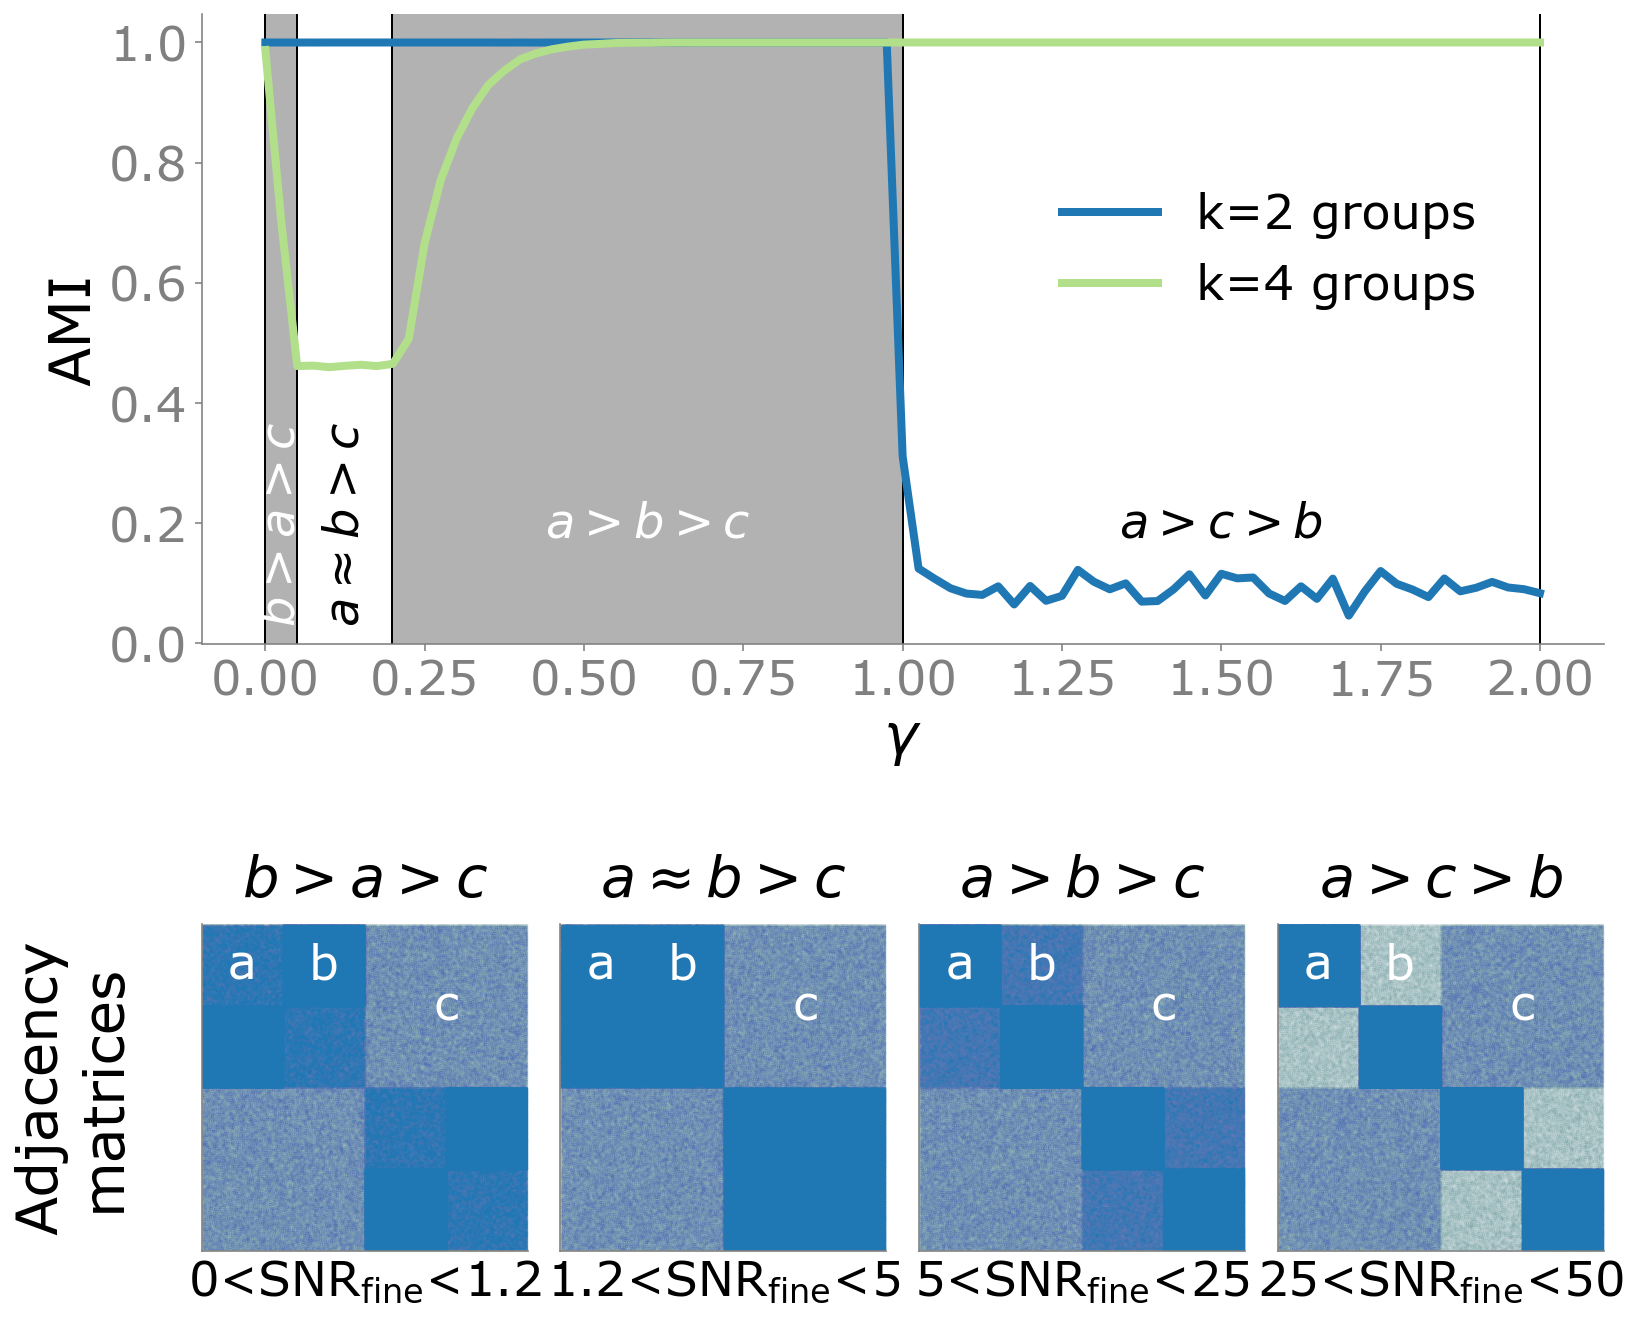

In [9]:
plt.rc('font', size=24)
fileid = '01-6gammaSNR25c150-2-2'
mean_scores = read_gamma_scores(True, fileid)
#fig = plt.figure(figsize=(16, 11))
fig = plt.figure(figsize=(12, 10))

widths = [16]
heights = [6, 5]
outer = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                           height_ratios=heights)

inner = gridspec.GridSpecFromSubplotSpec(1, 4,
                    subplot_spec=outer[1], wspace=0.1, hspace=0)

ax = fig.add_subplot(outer[0, 0])

gamma_thresh = [0, 0.05, 0.2, 1, 2]
gamma_thresh = [0, 0.049, 0.198, 1, 2]

# {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
for xi in gamma_thresh:
    ax.axvline(xi, lw=1, c='k')
#     ax.text(xi, 0.15, f'SNR = {xi*25:.1f}', rotation=90, ha='center', bbox={'facecolor':'w', 'edgecolor':'w', 'alpha':0.8})

ax.axvspan(0, 0.05, facecolor='k', alpha=0.3)
ax.axvspan(0.2, 1, facecolor='k', alpha=0.3)

ax.plot(mean_scores[:, 1], mean_scores[:, 2], c=color0, label='k=2 groups')
ax.plot(mean_scores[:, 1], mean_scores[:, 3], c=color1, label='k=4 groups')
ax.legend(frameon=False, loc=(.6,.5))
ax.set(title='', xlabel=r'$\gamma$', ylabel='AMI')

height=0.2
ax.text(0.025, height, r'$b>a>c$', rotation=90, ha='center', va='center', color='w', size=24)
ax.text(0.125, height, r'$a \approx b > c$', rotation=90, ha='center', va='center', color='k', size=24)
ax.text(0.6, height, r'$a>b>c$', rotation=0, ha='center', va='center', color='w', size=24)
ax.text(1.5, height, r'$a>c>b$', rotation=0, ha='center', va='center', color='k', size=24)


n=4 ** 7
k=2
snr = 25
c_bar = 150

gammas = [.0, .125, .6, 1.5]

try:
    Aas
except NameError:
    Aas = []

    for gamma in gammas:
        dendro = generation.create2paramGHRG(n, snr, c_bar, 2, k, gamma)
        Aa = dendro.sample_network()
        Aas.append(Aa)

relations = [r'$b>a>c$', r'$a \approx b > c$', r'$a>b>c$', r'$a>c>b$']
SNRf = r'SNR$_{\rm{fine}}$'

for ai, (Aa, rel) in enumerate(zip(Aas, relations)):
    ax = fig.add_subplot(inner[0, ai])
    ax.spy(Aa, marker='.', ms=0.01, rasterized=True)
    ax.set(xticks=[], yticks=[], title=rel) 
    ax.set_xlabel(f'{25*gamma_thresh[ai]:1.2g}<{SNRf}<{25*gamma_thresh[ai+1]:1.2g}', size=24)
    ax.text(n/4-n/8, n/4-n/8, 'a', ha='center', va='center', color='w', size=24)
    ax.text(n/2-n/8, n/4-n/8, 'b', ha='center', va='center', color='w', size=24)
    ax.text(n/2+n/4, n/2-n/4, 'c', ha='center', va='center', color='w', size=24)
    if ai == 0:
        ax.set(ylabel='Adjacency\nmatrices\n')


plt.tight_layout()
plt.savefig('KnownK2-2_snr25.pdf')

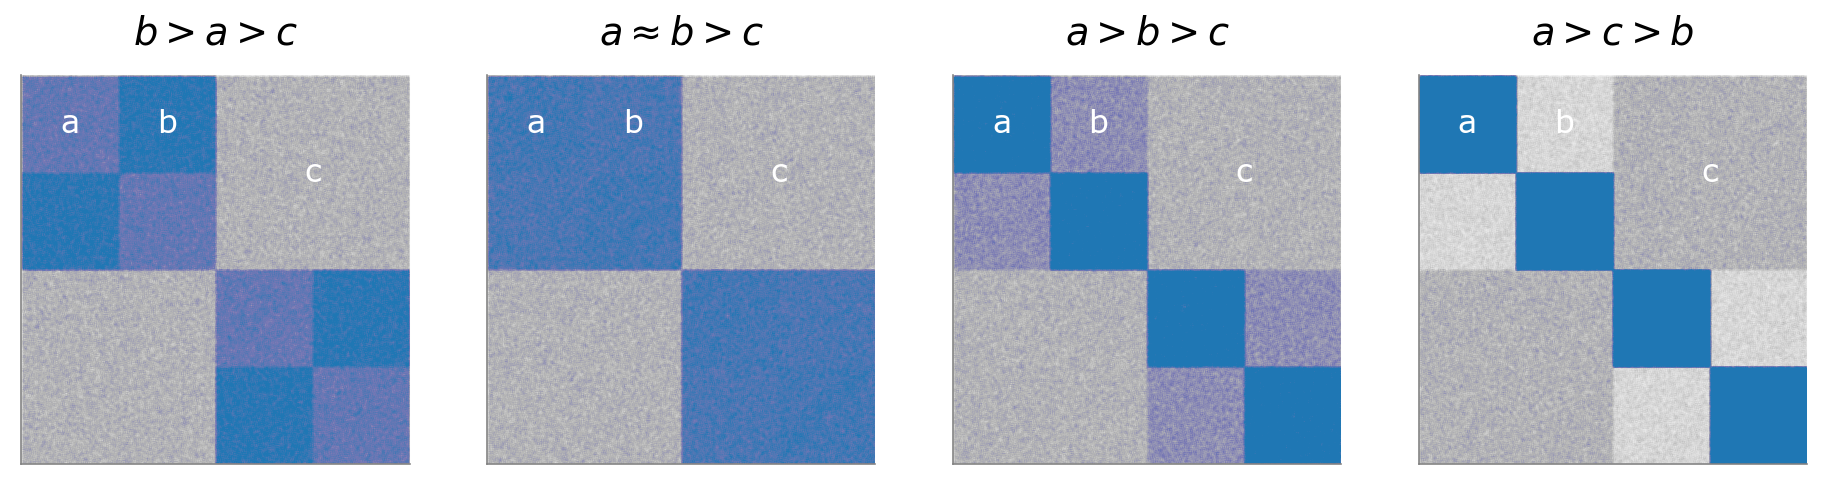

In [186]:
n=4 ** 7
k=2
snr = 25
c_bar = 150

gammas = [.0, .125, .6, 1.5]
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

# Aas = []

# for gamma, ax in zip(gammas, axs):
#     dendro = generation.create2paramGHRG(n, snr, c_bar, 2, k, gamma)
#     Aa = dendro.sample_network()
#     Aas.append(Aa)

relations = [r'$b>a>c$', r'$a \approx b > c$', r'$a>b>c$', r'$a>c>b$']

for ax, Aa, rel in zip(axs, Aas, relations):
    ax.spy(Aa, marker='.', ms=0.004, rasterized=True)
    ax.set(xticks=[], yticks=[], title=rel)
    ax.text(n/4-n/8, n/4-n/8, 'a', ha='center', va='center', color='w')
    ax.text(n/2-n/8, n/4-n/8, 'b', ha='center', va='center', color='w')
    ax.text(n/2+n/4, n/2-n/4, 'c', ha='center', va='center', color='w')


[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]
[0.05   0.0513 0.0526 0.0541 0.0556 0.0571 0.0588 0.0606 0.0625 0.0645
 0.0667 0.069  0.0714 0.0741 0.0769 0.08   0.0833 0.087  0.0909 0.0952
 0.1    0.1053 0.1111 0.1176 0.125  0.1333 0.1429 0.1538 0.1667 0.1818
 0.2    0.2222 0.25   0.2857 0.3333 0.4    0.5    0.6667 1.     2.    ]


array([0.02102768, 0.07062978, 0.12493435, 0.17197388, 0.20726991,
       0.24317348, 0.26997918, 0.29173721, 0.31247544, 0.3290845 ,
       0.34400319, 0.35785615, 0.36615969, 0.37678771, 0.38588841,
       0.39432477, 0.39945019, 0.40595144, 0.41289806, 0.41836612,
       0.42186648, 0.42532071, 0.42845879, 0.43225152, 0.43587614,
       0.4389483 , 0.4413342 , 0.44490091, 0.44584085, 0.44730647,
       0.45039622, 0.45233746, 0.45221569, 0.45487992, 0.45607032,
       0.45615631, 0.45777046, 0.45979492, 0.46109995])

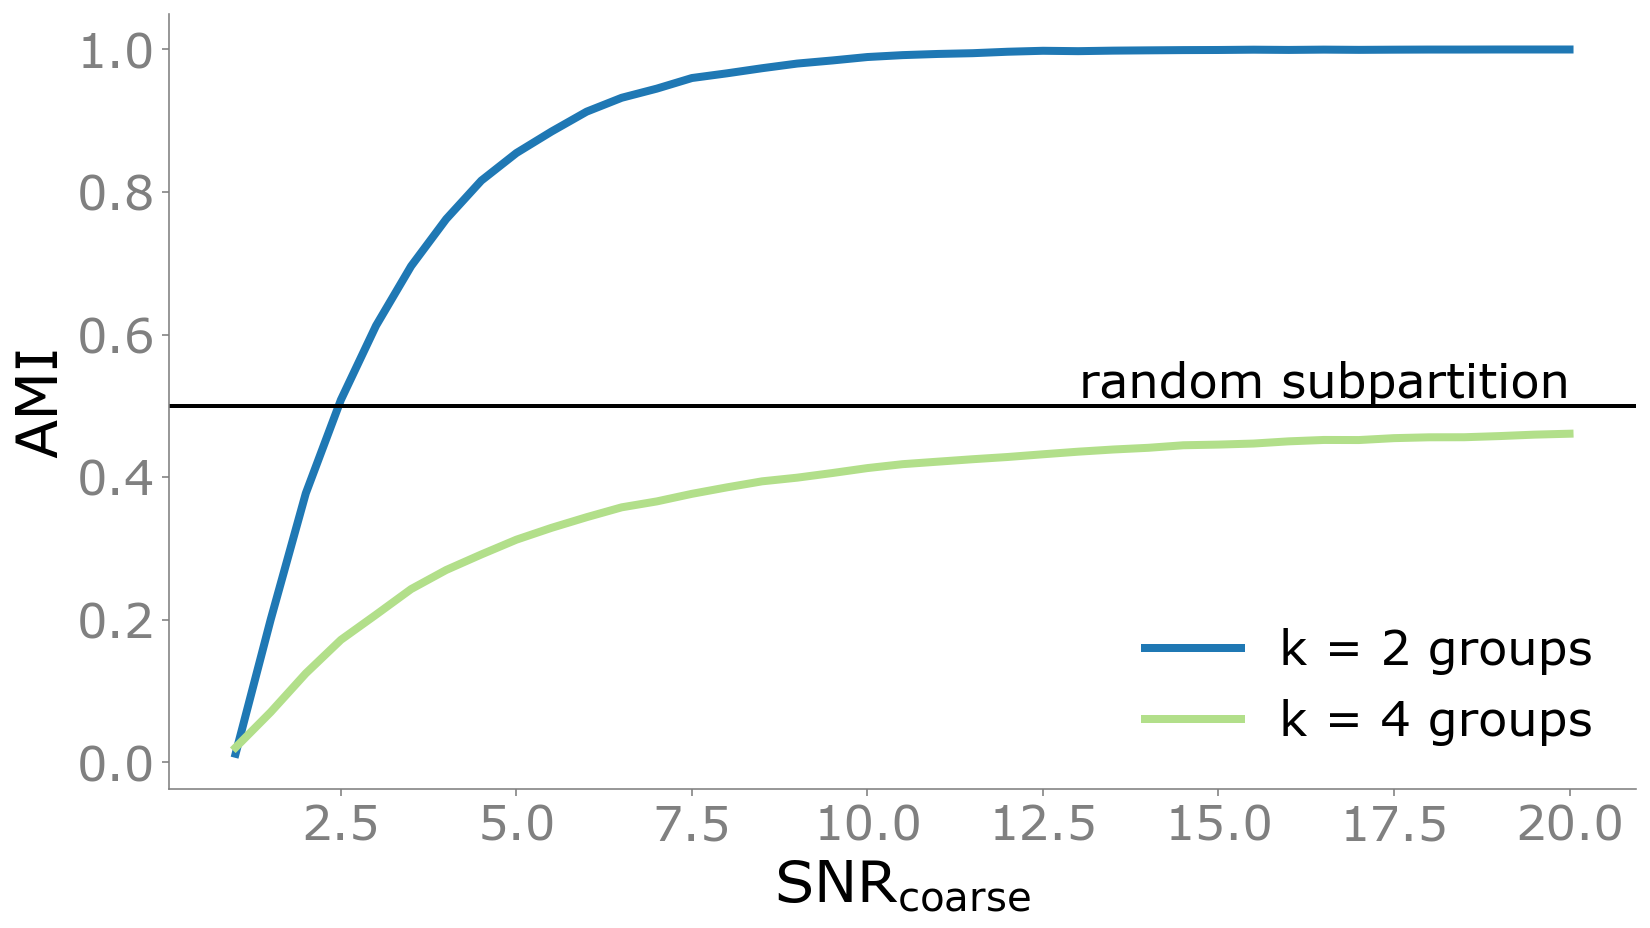

In [40]:
fileid = '02-6gammaSNR1-2-2'
mean_scores = read_gamma_scores(True, fileid, use_gamma=False)
plt.figure(figsize=(12, 7))
plt.plot(mean_scores[1:, 0], mean_scores[1:, 2], color=color0, label='k = 2 groups')
plt.plot(mean_scores[1:, 0], mean_scores[1:, 3], color=color1, label='k = 4 groups')
plt.axhline(0.4999, color='k', lw=2)
plt.text(20, 0.53, 'random subpartition', va='center', ha='right', bbox={'facecolor':'w', 'edgecolor':'w', 'alpha':0})
plt.legend(frameon=False)
ax = plt.gca()
ax.set(ylabel='AMI', xlabel=r'SNR$_{\rm{coarse}}$')
plt.tight_layout()
plt.savefig('FixedSNR1.pdf')

mean_scores[1:, 3]

In [56]:
def checkSNR(n, omega, c_bar = 50):
    k=omega.shape[0]
    Q = omega*n
    P = np.eye(k)/k
    evals, _ = np.linalg.eigh(P @ Q)
    evals = np.sort(evals)
    ev1 = evals[-1]
    ev2 = evals[-2]
    return ev2**2/ev1

def checkSNRcand(n, omega, c_bar = 50, i=-1, j=-2):
    k=omega.shape[0]
    Q = omega*n
    P = np.eye(k)/k
    evals, _ = np.linalg.eigh(P @ Q)
    evals = np.sort(evals)
    ev1 = evals[i]
    ev2 = evals[j]
    return ev2**2/ev1

def checkSNRall(n, omega):
    k=omega.shape[0]
    snr = np.inf
    for i in range(k-1):
        snr_j = 0
        for j in range(0, k-1, 2):
#             print(i, j, checkSNR(2*n/k, omega[i:(i+2), j:(j+2)]), 2*n/k)
            snr_j = max(snr_j, checkSNR(2*n/k, omega[i:(i+2), j:(j+2)]))
            snr_j = max(snr_j, checkSNR(2*n/k, omega[i:(i+2), j:(j+2)].T))
        snr = min(snr, snr_j)
    return snr
            

def checkSNRab(n, omega, c_bar = 50):
    k=omega.shape[0]
    a = omega[0, 0]*n
    b = np.mean(omega[0, 1:]*n)
    c_bar = np.mean(omega[0, :]*n)
    print(f'a:{a:.2f} b:{b:.2f} cbar:{c_bar:.2f}')
    return ((a-b)**2) / (k*(a+(k-1)*b))

def checkSNRup(n, omega, k, c_bar = 50):
#     print(k, omega.shape[0])
    kmax=omega.shape[0]
    a = np.mean(omega[0, :k]*n)
    b = np.mean(omega[0, k:]*n)
    print(f'a:{a:.2f} b:{b:.2f}')
    k=kmax/k
    return ((a-b)**2) / (k*(a+(k-1)*b))

def checkRecov(n, omega, k, c_bar=50):
    k=omega.shape[0]
    Q = omega*n
    P = np.eye(k)/k
    PQ = P @ Q
    snr = np.inf
    for i in range(k):
        for j in range(i+1, k):
            snr = min(CHDiv(PQ[:, i], PQ[:, j]), snr)
    return snr

# def CHdiv(mu, nu):
    
            

In [46]:
n = 4 ** 7
snr2=1
k=2
for snr1 in np.arange(1, 20.1, .5):
    gamma = snr2/snr1
    omega1 = generation.calculate2paramOmega(n, snr1, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=1)
    cout1 = omega1[0, -1]
    omega2_part = generation.calculate2paramOmega(n, snr1, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=2)
    omega2 = np.kron(np.eye(k), omega2_part)
    omega2[(omega2==0).nonzero()] = cout1
    print(snr1, snr2, gamma, checkSNR(n, omega2))
    

KS Detectable:  True | Link Probabilities in / out per block:  0.009902798383417717 0.008407748491582281
Number of nodes: 16384 | In / out degree: 162.24744871391587 / 137.7525512860841
KS Detectable:  True | Link Probabilities in / out per block:  0.011397848275253152 0.008407748491582281
Number of nodes: 16384 | In / out degree: 186.74234614174765 / 137.7525512860841
1.0 1.0 1.0000000000000036
KS Detectable:  True | Link Probabilities in / out per block:  0.01007080078125 0.00823974609375
Number of nodes: 16384 | In / out degree: 165.0 / 135.0
KS Detectable:  True | Link Probabilities in / out per block:  0.011397848275253152 0.008743753287246844
Number of nodes: 16384 | In / out degree: 186.74234614174765 / 143.2576538582523
1.5 0.6666666666666666 1.4999999999999962
KS Detectable:  True | Link Probabilities in / out per block:  0.010212433354229052 0.00809811352077095
Number of nodes: 16384 | In / out degree: 167.3205080756888 / 132.67949192431124
KS Detectable:  True | Link Probabi

In [63]:
n = 4 ** 7
snr1=25
k=2
for gamma in np.linspace(0, 2, 21):
#     gamma = snr2/snr1
    snr2 = gamma * snr1
    omega1 = generation.calculate2paramOmega(n, snr1, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=1)
    cout1 = omega1[0, -1]
    omega2_part = generation.calculate2paramOmega(n, snr1, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=2)
    omega2 = np.kron(np.eye(k), omega2_part)
    omega2[(omega2==0).nonzero()] = cout1
    print(f'''\n {snr1} {snr2} {gamma} 
              {checkSNR(n, omega2):.1f} {checkSNR(n/2, omega2[:2,:2]):.1f} {checkSNRcand(n, omega2, i=-1, j=0):.1f} {checkSNRcand(n, omega2, i=-2, j=0):.1f} \n''')

KS Detectable:  True | Link Probabilities in / out per block:  0.01289289816708859 0.005417648707911411
Number of nodes: 16384 | In / out degree: 211.23724356957945 / 88.76275643042055
KS Detectable:  True | Link Probabilities in / out per block:  0.0091552734375 0.01663052289667718
Number of nodes: 16384 | In / out degree: 150.0 / 272.4744871391589

 25 0.0 0.0 
              25.0 8.9 6.2 15.3 

KS Detectable:  True | Link Probabilities in / out per block:  0.01289289816708859 0.005417648707911411
Number of nodes: 16384 | In / out degree: 211.23724356957945 / 88.76275643042055
KS Detectable:  True | Link Probabilities in / out per block:  0.012701095592841263 0.013084700741335914
Number of nodes: 16384 | In / out degree: 208.09475019311125 / 214.37973694604761

 25 2.5 0.1 
              25.0 0.0 0.0 0.0 

KS Detectable:  True | Link Probabilities in / out per block:  0.01289289816708859 0.005417648707911411
Number of nodes: 16384 | In / out degree: 211.23724356957945 / 88.76275643042

In [65]:
n = 4 ** 7
snr2=1
k=2
for gamma in np.linspace(0.1, 2, 20):
#     gamma = snr2/snr1
    snr1 = snr2 / gamma 
    omega1 = generation.calculate2paramOmega(n, snr1, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=1)
    cout1 = omega1[0, -1]
    omega2_part = generation.calculate2paramOmega(n, snr1, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=2)
    omega2 = np.kron(np.eye(k), omega2_part)
    omega2[(omega2==0).nonzero()] = cout1
    print(f'''\n {snr1} {snr2} {gamma} 
              {checkSNR(n, omega2):.1f} {checkSNR(n/2, omega2[:2,:2]):.1f} {checkSNRcand(n, omega2, i=-1, j=0):.1f} {checkSNRcand(n, omega2, i=-2, j=0):.1f} \n''')

KS Detectable:  True | Link Probabilities in / out per block:  0.011519154874394175 0.006791392000605825
Number of nodes: 16384 | In / out degree: 188.72983346207417 / 111.27016653792583
KS Detectable:  True | Link Probabilities in / out per block:  0.011397848275253152 0.011640461473535195
Number of nodes: 16384 | In / out degree: 186.74234614174765 / 190.71732078240063

 10.0 1 0.1 
              10.0 0.0 0.0 0.0 

KS Detectable:  True | Link Probabilities in / out per block:  0.01082679003144887 0.0074837568435511285
Number of nodes: 16384 | In / out degree: 177.3861278752583 / 122.61387212474169
KS Detectable:  True | Link Probabilities in / out per block:  0.011397848275253152 0.010255731787644587
Number of nodes: 16384 | In / out degree: 186.74234614174765 / 168.02990960876892

 5.0 1 0.2 
              5.0 0.2 0.1 0.8 

KS Detectable:  True | Link Probabilities in / out per block:  0.010520061021423211 0.007790485853576789
Number of nodes: 16384 | In / out degree: 172.3606797749

In [144]:
cout2 = omega2_part[0, -1]
omega3_part2 = generation.calculate2paramOmega(n, snr, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=3)
omega3_part = np.kron(np.eye(3), omega3_part2)
omega3_part[(omega3_part==0).nonzero()] = cout2

omega3 = np.kron(np.eye(3), omega3_part)
omega3[(omega3==0).nonzero()] = cout1

checkSNR(n, omega3), checkSNRab(n, omega3), checkSNRup(n, omega3, k), checkSNRup(n, omega3, k*k), checkSNRall(n, omega3)

KS Detectable:  True | Link Probabilities in / out per block:  0.04854852085612675 0.008276275253312962
Number of nodes: 19683 | In / out degree: 955.5805360111428 / 162.90192581095903
a:955.58 b:119.02 cbar:150.00
a:427.13 b:115.36
a:227.46 b:111.27


(10.000000000000002,
 6.400000000000004,
 7.999999999999994,
 9.999999999999993,
 20.80661042864432)

In [145]:
checkSNR(4374, omega2[7:,6:8].T)

17.96630853223909

In [146]:
4374*omega2[7:,6:8]

array([[28.36120795, 94.91736205],
       [28.36120795, 28.36120795]])

In [147]:
n = 4**7
k = 2
gamma = .05
snr=25
c_bar=150
omega1 = generation.calculate2paramOmega(n, snr, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=1)
checkSNR(n, omega1), checkSNRab(n, omega1), checkSNRall(n, omega1)

KS Detectable:  True | Link Probabilities in / out per block:  0.01289289816708859 0.005417648707911411
Number of nodes: 16384 | In / out degree: 211.23724356957945 / 88.76275643042055
a:211.24 b:88.76 cbar:150.00


(24.999999999999996, 24.999999999999996, 24.999999999999996)

In [148]:
cout1 = omega1[0, -1]
omega2_part = generation.calculate2paramOmega(n, snr, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=2)
omega2 = np.kron(np.eye(k), omega2_part)
omega2[(omega2==0).nonzero()] = cout1
checkSNR(n, omega2), checkSNRab(n, omega2), checkSNRup(n, omega2, k), checkSNRall(n, omega2)

KS Detectable:  True | Link Probabilities in / out per block:  0.011662548328423308 0.014123248005753875
Number of nodes: 16384 | In / out degree: 191.07919181288747 / 231.39529532627148
a:191.08 b:136.31 cbar:150.00
a:211.24 b:88.76


(25.00000000000001, 1.2500000000000004, 25.00000000000001, 0.9618262474903646)

In [149]:
print(omega2, k)
print(omega2[:2,:2], k)
print(checkSNR(n/2, omega2[:2,:2]), checkSNRab(n/2, omega2[:2,:2]))
print(checkSNR(n, omega2[:2,:2]), checkSNRab(n, omega2[:2,:2]))

[[0.01166255 0.01412325 0.00541765 0.00541765]
 [0.01412325 0.01166255 0.00541765 0.00541765]
 [0.00541765 0.00541765 0.01166255 0.01412325]
 [0.00541765 0.00541765 0.01412325 0.01166255]] 2
[[0.01166255 0.01412325]
 [0.01412325 0.01166255]] 2
a:95.54 b:115.70 cbar:105.62
0.9618262474903646 0.9618262474903646
a:191.08 b:231.40 cbar:211.24
1.9236524949807292 1.9236524949807292


KS Detectable:  True | Link Probabilities in / out per block:  0.01289289816708859 0.005417648707911411
Number of nodes: 16384 | In / out degree: 211.23724356957945 / 88.76275643042055
KS Detectable:  True | Link Probabilities in / out per block:  0.010928184515170632 0.01485761181900655
Number of nodes: 16384 | In / out degree: 179.04737509655564 / 243.4271120426033
KS Detectable:  True | Link Probabilities in / out per block:  0.01289289816708859 0.005417648707911411
Number of nodes: 16384 | In / out degree: 211.23724356957945 / 88.76275643042055
KS Detectable:  True | Link Probabilities in / out per block:  0.011064757105830159 0.01472103922834702
Number of nodes: 16384 | In / out degree: 181.28498042192132 / 241.18950671723758
KS Detectable:  True | Link Probabilities in / out per block:  0.01289289816708859 0.005417648707911411
Number of nodes: 16384 | In / out degree: 211.23724356957945 / 88.76275643042055
KS Detectable:  True | Link Probabilities in / out per block:  0.011192193

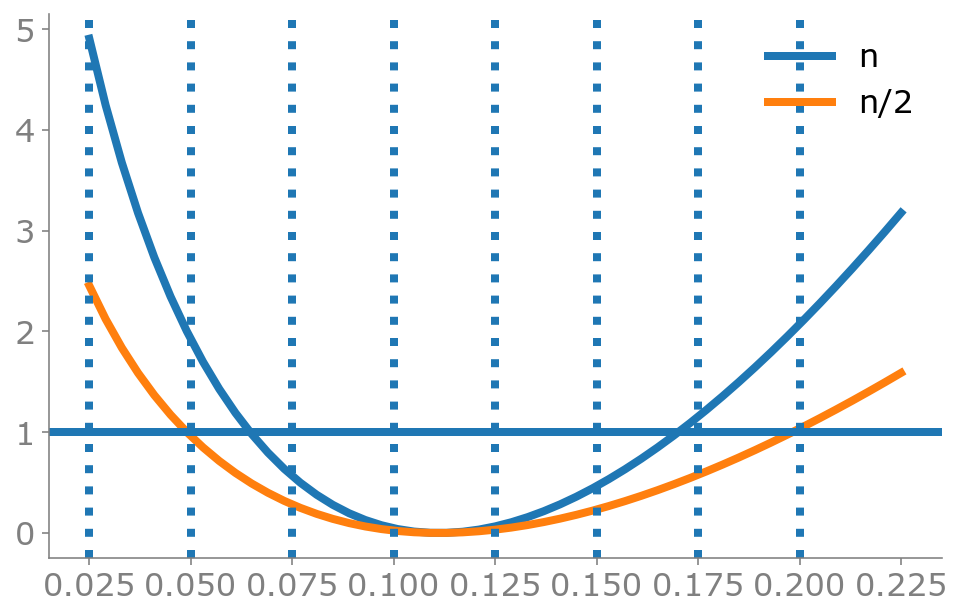

In [139]:
n = 4**7
k = 2

snr=25
c_bar=150

gammas = np.linspace(0.025, 0.225, 51)
snrn = []
snrn2 = []

for gamma in gammas:
    omega1 = generation.calculate2paramOmega(n, snr, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=1)

    cout1 = omega1[0, -1]
    omega2_part = generation.calculate2paramOmega(n, snr, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=2)
    omega2 = np.kron(np.eye(k), omega2_part)
    omega2[(omega2==0).nonzero()] = cout1
    snrn.append(checkSNR(n, omega2[:2,:2]))
    snrn2.append(checkSNR(n/2, omega2[:2,:2]))

plt.plot(gammas, snrn, label='n')
plt.plot(gammas, snrn2, label='n/2')

plt.legend(frameon=False)

for i in np.arange(0.025, 0.225, 0.025):
    plt.axvline(i, ls=':')

plt.axhline(1)


In [140]:
omega1 = generation.calculate2paramOmega(n, snr=2, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=1)
print(omega1)
print(checkSNR(n, omega1))
omega1 = omega1[::-1,:]
omega1[0, 1] = omega1[0, 0]
print(omega1)
print(checkSNR(n, omega1.T))

KS Detectable:  True | Link Probabilities in / out per block:  0.010212433354229052 0.00809811352077095
Number of nodes: 16384 | In / out degree: 167.3205080756888 / 132.67949192431124
[[0.01021243 0.00809811]
 [0.00809811 0.01021243]]
2.0000000000000013
[[0.00809811 0.00809811]
 [0.01021243 0.00809811]]
0.0


In [127]:
def evecs_from_BetheHessian(A, num_groups=-1, regularizer='BHa',
                              clustermode='KM', norm=False):
    """
    Perform one round of spectral clustering using the Bethe Hessian
    """

    # construct both the positive and the negative variant of the BH
    BH_pos = BetheHessian(A, regularizer)
    BH_neg = BetheHessian(A, regularizer+'n')

    BH_pos.find_k_eigenvectors(num_groups, which='SA')
    BH_neg.find_k_eigenvectors(num_groups, which='SA')

    # combine both sets of eigenvales and eigenvectors and take first k
    combined_evecs = np.hstack([BH_pos.evecs, BH_neg.evecs])
    combined_evals = np.hstack([BH_pos.evals, BH_neg.evals])
    index = np.argsort(combined_evals)
    combined_evecs = combined_evecs[:, index[:num_groups]]

    return combined_evecs

Hierarchy Level:  1
KS Detectable:  True | Link Probabilities in / out per block:  0.01289289816708859 0.005417648707911411
Number of nodes: 16384 | In / out degree: 211.23724356957945 / 88.76275643042055
Hierarchy Level:  2
KS Detectable:  True | Link Probabilities in / out per block:  0.025012672188435767 0.000773124145741412
Number of nodes: 16384 | In / out degree: 409.8076211353316 / 12.666866003827295


(409.8076211353316,
 12.666866003827295,
 88.76275643042055,
 88.76275643042055,
 12.666866003827309)

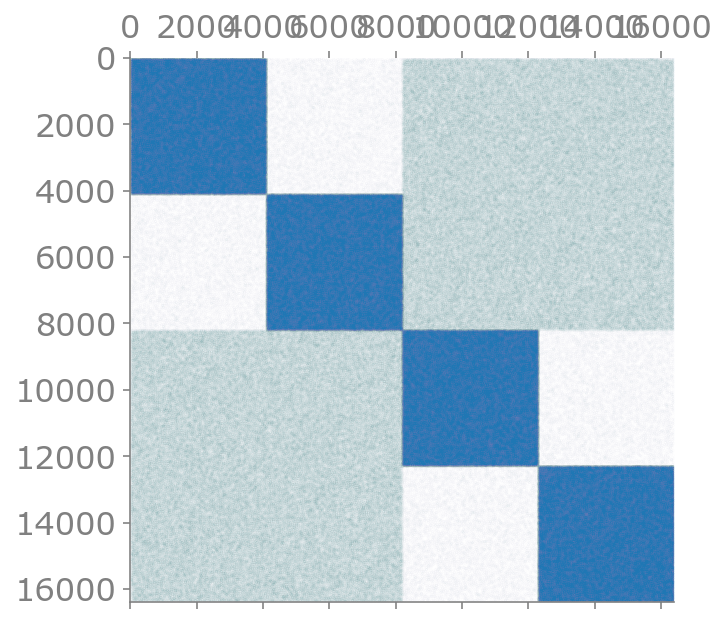

In [326]:
from collections import Counter
n=4 ** 7
k=2
snr = 25
c_bar = 150
gamma = 2
dendro = generation.create2paramGHRG(n, snr, c_bar, 2, k, gamma)
Aa = dendro.sample_network()

plt.spy(Aa, marker='.', ms=0.01, rasterized=True)

# combined_evecs = evecs_from_BetheHessian(Aa, num_groups=k*k)
# for true_part in dendro:
#     k = true_part.k
#     inf_part = cluster.find_partition(combined_evecs, k, normalization=False)
#     ami = metrics.adjusted_mutual_info_score(inf_part.pvec, 
#                                              true_part.pvec_expanded,
#                                              average_method="arithmetic")
#     print(f'k:{k} ami:{ami:.3f}', Counter(inf_part.pvec))
c1 = dendro[0].omega_list[0]*n
c2 = dendro[1].omega_list[0]*n
a = c2[0,0]
b = c2[0,1]
c = c1[0,1]
a, b, c, (c_bar-np.sqrt(snr*c_bar)), (c_bar+k*np.sqrt(snr*c_bar)*(1-np.sqrt(gamma))-np.sqrt(snr*c_bar*gamma))

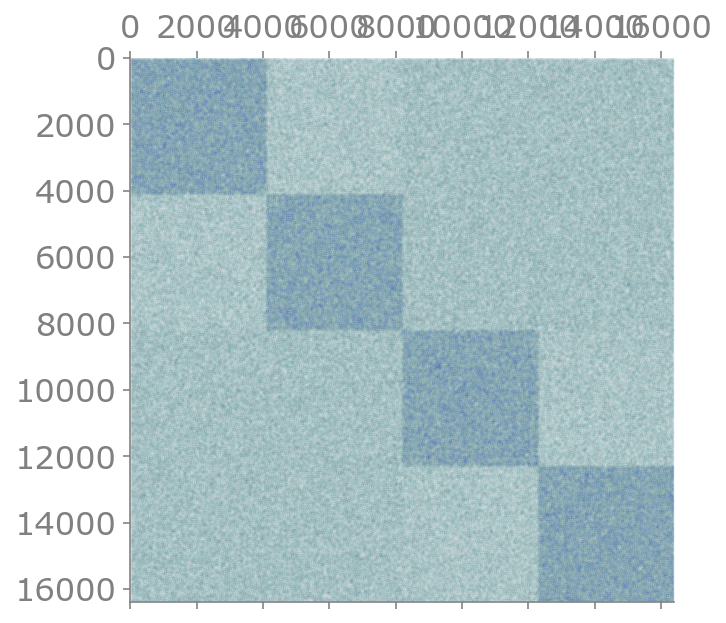

In [317]:
plt.spy(Aa, marker='.', ms=0.01, rasterized=True)

In [318]:
c1 = dendro[0].omega_list[0]*n
c2 = dendro[1].omega_list[0]*n
a = c2[0,0]
b = c2[0,1]
c = c1[0,1]
a, b, c

(196.47580015448898, 128.01909727334277, 137.7525512860841)

In [259]:
k=4
pvec4 = np.kron(np.arange(k), np.ones(int(n/k)))
k=2
for g in range(k):
    pvec2[int(g*n/k):int((g+1)*n/k)] = np.random.permutation(pvec4[int(g*n/k):int((g+1)*n/k)])

metrics.adjusted_mutual_info_score(pvec4, pvec2)

0.49995426281990973

In [253]:
k=4
pvec4 = np.kron(np.arange(k), np.ones(int(n/k)))
pvec4[pvec4==1] = 1
pvec4[pvec4==2] = 1
pvec4[pvec4==3] = 1
k=2
pvec2 = np.kron(np.arange(k), np.ones(int(n/k)))
metrics.adjusted_mutual_info_score(pvec4, pvec2)

0.3436791072859511

137.7525512860841

In [770]:
np.linspace(0,2,81)

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
       1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
       1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 ,
       1.575, 1.6  , 1.625, 1.65 , 1.675, 1.7  , 1.725, 1.75 , 1.775,
       1.8  , 1.825, 1.85 , 1.875, 1.9  , 1.925, 1.95 , 1.975, 2.   ])

array([22.36067977, 22.36067977, 50.        ])

In [392]:
np.linalg.eigh(P @ (omega * n))

(array([22.36067977, 22.36067977, 50.        ]),
 array([[ 0.3086067 , -0.75592895, -0.57735027],
        [-0.80895702,  0.11070323, -0.57735027],
        [ 0.50035032,  0.64522571, -0.57735027]]))

In [387]:
P

array([[0.33333333, 0.        , 0.        ],
       [0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333]])

In [9]:
bb[0]

NameError: name 'bb' is not defined